<a href="https://colab.research.google.com/github/aletbm/HuggingFace_AI_Agent_AutoEval_FinalProject/blob/main/HF_Final_Project_AI_Agent_AutoEval_Alexander_Daniel_Rios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hugging Face Agent Course - Final Project - By [Alexander Daniel Rios](https://linktr.ee/aletbm)
<img src="https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit4/thumbnail.jpg">

# Clone the HF Space

In [ ]:
!git clone https://huggingface.co/spaces/AleTBM/AI_Agent_AutoEval

Cloning into 'Final_Assignment_Template'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 193 (delta 50), reused 0 (delta 0), pack-reused 115 (from 1)
Receiving objects: 100% (193/193), 87.90 KiB | 4.19 MiB/s, done.
Resolving deltas: 100% (112/112), done.


# Requirements

In [ ]:
%cd Final_Assignment_Template

/content/Final_Assignment_Template


In [ ]:
%%writefile requirements.txt

gradio
requests
langgraph
langchain
langchain-huggingface
langchain-community
langchain-experimental
langchain-litellm
litellm==1.67.0
unstructured[pdf]
duckduckgo-search
playwright
openai-whisper
wikipedia
arxiv
yt_dlp
pytesseract
pyld
docx2txt
openpyxl
pymupdf
pdfplumber
biopython
qwen-vl-utils[decord]==0.0.8
python-pptx
ratelimit
tenacity

Overwriting requirements.txt


In [ ]:
!pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 11.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 38.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 20.

# Log in HF

In [ ]:
from huggingface_hub import login
from google.colab import userdata

login(token=userdata.get('HF_TOKEN'))

# Environment variables

In [ ]:
load_user_data = False
with open(".env", "w") as env:
    env.write(f"SPACE_HOST={userdata.get('SPACE_HOST') if load_user_data == True else 'YOUR KEY'}\n")
    env.write(f"SPACE_ID={userdata.get('SPACE_ID') if load_user_data == True else 'YOUR KEY'}\n")
    env.write(f"GEMINI_API_KEY_1={userdata.get('GOOGLE_API_KEY_1') if load_user_data == True else 'YOUR KEY'}\n")
    env.write(f"GEMINI_API_KEY_2={userdata.get('GOOGLE_API_KEY_2') if load_user_data == True else 'YOUR KEY'}\n")
    env.write(f"GEMINI_API_KEY_3={userdata.get('GOOGLE_API_KEY_3') if load_user_data == True else 'YOUR KEY'}\n")
    env.write(f"USER_AGENT=MyAgent\n")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
gaia_files = "/content/drive/MyDrive/GAIA/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tools

In [ ]:
%%writefile tools.py

import os
import requests
import tempfile
from langchain.docstore.document import Document
from langchain.tools import Tool, StructuredTool, tool
from typing import Tuple, List
from langchain_core.messages import AIMessage
from langchain_community.tools import DuckDuckGoSearchResults, DuckDuckGoSearchRun
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain_community.agent_toolkits.playwright.toolkit import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langchain_community.document_loaders.wikipedia import WikipediaLoader
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_community.document_loaders.arxiv import ArxivLoader
from langchain_community.document_loaders.text import TextLoader
from langchain_community.document_loaders.word_document import Docx2txtLoader
import yt_dlp
import json
from Bio.PDB import PDBParser
import pandas as pd
from openpyxl import load_workbook
import math
import pdfplumber
from pptx import Presentation
import zipfile
from ratelimit import limits, sleep_and_retry
from tenacity import retry, wait_exponential, stop_after_attempt, retry_if_exception_type
from duckduckgo_search.exceptions import DuckDuckGoSearchException
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import whisper

model_whisper = whisper.load_model("base")
model_image = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
processor_image = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

@tool
def add(a: str, b: str) -> str:
    """Adds two numbers provided as strings and returns the result as a string."""
    return str(float(a) + float(b))

@tool
def subtract(a: str, b: str) -> str:
    """Subtracts the second number from the first, both provided as strings, and returns the result as a string."""
    return str(float(a) - float(b))

@tool
def multiply(a: str, b: str) -> str:
    """Multiplies two numbers provided as strings and returns the result as a string."""
    return str(float(a) * float(b))

@tool
def divide(a: str, b: str) -> str:
    """Divides the first number by the second, both provided as strings, and returns the result as a string. The divisor must not be zero."""
    return str(float(a) / float(b))

@tool
def power(a: str, b: str) -> str:
    """Raises the first number (base) to the power of the second number (exponent), both provided as strings, and returns the result as a string."""
    return str(float(a) ** float(b))

@tool
def square_root(a: str) -> str:
    """Calculates the square root of a number provided as a string and returns the result as a string. The number must be non-negative."""
    return str(math.sqrt(float(a)))

@tool
def get_information_from_wikipedia(query: str) -> str:
    """
    Search for relevant Wikipedia pages based on a user query and return their URLs.

    This tool uses WikipediaLoader to retrieve up to 10 Wikipedia articles related to the input query.
    The output consists of a formatted list of URLs pointing to these articles. These URLs can be used
    by web automation tools or agents to navigate, scrape, and extract valuable information such as
    text, tables, infoboxes, images, and references that may help answer the user's question.

    Args:
        query (str): A user-provided search query.

    Returns:
        str: A formatted explanation with a list of Wikipedia URLs related to the query.
    """
    search_docs = WikipediaLoader(query=query, load_max_docs=10).load()
    urls = [doc.metadata["source"] for doc in search_docs]
    url_list = "\n".join(f"- {url}" for url in urls)

    return f"""Wikipedia search completed for query: "{query}".

You must now browse the following Wikipedia pages to extract detailed information. Use `navigate_browser` to explore each URL:

Relevant Wikipedia URLs:
{url_list}

Instructions:
- Visit each URL using `navigate_browser`.
- Extract full page content, infoboxes, tables, and references.
- Use hyperlinks from the page to recursively follow relevant internal links if necessary."""

@tool
def get_information_from_arxiv(query: str) -> str:
    """
    Searches the arXiv database for academic papers related to a given query and returns up to 3 relevant results,
    including source metadata and a preview of each paper's content.

    This function queries the arXiv database for papers matching the provided search term. It retrieves up to 3 papers
    with content limited to 10,000 characters each. The results are formatted in XML-like structure with metadata
    such as the title, authors, and page number (if available).

    Args:
        query (str): The search term or topic to query on arXiv (e.g., "machine learning").

    Returns:
        str: A formatted string containing the metadata (title, authors, page number) and content preview
             for each of the top 3 relevant papers found on arXiv.
    """
    search_docs = ArxivLoader(query=query, load_max_docs=3, doc_content_chars_max=10000).load()
    content = ""
    for doc in search_docs:
        content += f"Title: {doc.metadata['Title']}\n"
        content += f"Authors: {doc.metadata['Authors']}\n"
        content += f"Summary: {doc.metadata['Summary']}\n"
        content += f"Published: {doc.metadata['Published']}\n\n"

    return f"""Arxiv search completed for query: "{query}".

Relevant Arxiv papers:
{content}

Instructions:
- Search the paper link throught it's title.
- Visit each URL using `navigate_browser`.
- Extract full page content, infoboxes, tables, and references.
- Use hyperlinks from the page to recursively follow relevant internal links if necessary."""

@tool
def get_web_page(url: str) -> str:
    """
    Use this to extract text from basic HTML pages. Works well for static websites without JavaScript.

    This function retrieves the content of a webpage at the specified URL and extracts all the visible text.

    Args:
        url (str): The URL of the public webpage to fetch (e.g., "https://example.com").

    Returns:
        str: A string containing the visible text content extracted from the webpage.

    Example:
        url = "https://en.wikipedia.org/wiki/Python_(programming_language)"
        page_text = get_web_page(url)
        print(page_text)

    In this example, the function will return the visible text from the Wikipedia page about "Python programming language",
    excluding JavaScript-generated or hidden content, formatted as plain text.
    """
    loader = WebBaseLoader(url)
    docs = loader.load()
    content = "\n\n".join([doc.page_content for doc in docs])
    return f"""The web page content is:

{content}

Instructions:
If the information is not sufficient:
- Visit the URL {url} using `navigate_browser`.
- Extract full page content, infoboxes, tables, and references.
- Use hyperlinks from the page to recursively follow relevant internal links if necessary."""

def download_video_from_youtube(url, tempdirname):
    """
    Downloads the best quality video from YouTube (MP4 format) and saves it in the specified directory.

    This function fetches the video from the provided YouTube URL, ensuring that the video format is MP4 with a
    resolution of at least 1080p. It also downloads subtitles if available, saving them in English as SRT files.

    Args:
        url (str): The YouTube video URL to download (e.g., "https://www.youtube.com/watch?v=example").
        tempdirname (str): The directory where the downloaded video and subtitles will be saved.

    Returns:
        str: The path to the downloaded video file (MP4 format).

    Example:
        url = "https://www.youtube.com/watch?v=example"
        tempdirname = "/tmp/videos"
        video_filepath = download_video_from_youtube(url, tempdirname)
        print(video_filepath)

    In this example, the function will download the best quality video and subtitles from the given YouTube URL
    and save them in the specified directory.
    """

    ydl_opts = {
        'format': '(bestvideo[width>=1080][ext=mp4]/bestvideo)+bestaudio/best', #Ensures best settings
        'writesubtitles': True, #Adds a subtitles file if it exists
        'writeautomaticsub': True, #Adds auto-generated subtitles file
        'subtitle': '--write-sub --sub-lang en', #writes subtitles file in english
        'subtitlesformat':'srt', #writes the subtitles file in "srt" or "ass/srt/best"
        'skip_download': False, #skips downloading the video file
        "merge_output_format": "mp4",
        'outtmpl':f"{tempdirname}/%(title)s.%(ext)s",
        'quiet': True,
        'cookiefile': "./cookies.txt"
        }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(url, download=True)
        video_title = info_dict.get('title', None)
        filepath = ydl.prepare_filename(info_dict)
    print(f"Download {filepath.split('/')[-1]} Successful!")
    return filepath

def download_audio_from_youtube(url, tempdirname):
    """
    Downloads the best quality audio (MP3 format) from a YouTube video and saves it in the specified directory.

    This function fetches the audio from the provided YouTube URL in the best available format and saves it
    as an MP3 file. It does not download the video.

    Args:
        url (str): The YouTube video URL to extract audio from (e.g., "https://www.youtube.com/watch?v=example").
        tempdirname (str): The directory where the audio file will be saved.

    Returns:
        str: The path to the downloaded audio file (MP3 format).

    Example:
        url = "https://www.youtube.com/watch?v=example"
        tempdirname = "/tmp/audio"
        audio_filepath = download_audio_from_youtube(url, tempdirname)
        print(audio_filepath)

    In this example, the function will download the best quality audio (MP3) from the YouTube URL
    and save it in the specified directory.
    """

    ydl_opts = {
        'extract_audio': True,
        'format': 'bestaudio',
        'outtmpl': f"{tempdirname}/%(title)s.mp3",
        'quiet': True,
        'cookiefile': "./cookies.txt"
        }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(url, download=True)
        audio_title = info_dict.get('title', None)
        filepath = ydl.prepare_filename(info_dict)
    print(f"Download {filepath.split('/')[-1]} Successful!")
    return filepath

def download_youtube_data(url: str) -> str:
    """
    Downloads the description and comments of a YouTube video using the yt-dlp Python API.

    Args:
        url (str): The URL of the YouTube video.

    Returns:
        str: File paths and summary of downloaded content.
    """
    ydl_opts = {
        'quiet': True,
        'extract_flat': False,
        'skip_download': True,
        'getcomments': True,
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(url, download=False)

        # Guardar descripción
        description = info.get("description", "No description found.")

        # Guardar comentarios
        comments = info.get("comments", [])
        comment_texts = [c["text"] for c in comments if "text" in c]

        return (
            f"Downloaded video data:\n\n"
            f"Description: {description}\n"
            f"Comments: {comment_texts}\n"
        )

    except Exception as e:
        return f"Error extracting video data: {str(e)}"

@tool
def get_information_from_youtube(url: str) -> str:
    """
    Downloads a YouTube video, extracts the audio, and returns a transcription of the audio.

    This function first downloads the video and audio from the given YouTube URL. Then, it transcribes the
    speech from the audio file using a transcription service.

    Args:
        url (str): The YouTube video URL to download and transcribe (e.g., "https://www.youtube.com/watch?v=example").

    Returns:
        str: The transcription text of the audio content extracted from the YouTube video.

    Example:
        url = "https://www.youtube.com/watch?v=example"
        transcription = get_information_from_youtube(url)
        print(transcription)

    In this example, the function will download the video and audio from YouTube, extract the audio, and
    return a transcription of the spoken content in the video.
    """

    tempdirname = tempfile.TemporaryDirectory()
    video_filepath = download_video_from_youtube(url, tempdirname)
    audio_filepath = download_audio_from_youtube(url, tempdirname)
    youtube_data = download_youtube_data(url)

    return youtube_data + get_information_from_audio.invoke(audio_filepath)

@tool
def get_information_from_audio(filepath: str) -> str:
    """
    Transcribes speech from an audio file into text using a speech-to-text model.

    This function takes an audio file and converts the spoken content into written text using a speech-to-text model.
    It is useful when you need to extract information from voice recordings.

    Args:
        filepath (str): The path to the audio file (e.g., ".wav", ".mp3", etc.).
                         The file should contain spoken content to be transcribed.

    Returns:
        str: The transcribed text from the audio file.

    Example:
        filepath = "/path/to/audiofile.wav"
        transcription = get_information_from_audio(filepath)
        print(transcription)

    In this example, the function will transcribe the speech from the specified audio file and return the
    transcribed text that can be further analyzed or used in other processes.
    """
    result = model_whisper.transcribe(filepath)
    return (f"Transcription of audio file:\n\n{result['text']}"
            "Please verify this information by cross-checking with reliable external sources such as web searches, Wikipedia, or other knowledge bases before finalizing your response."
            "If necessary, supplement the transcription with additional relevant information to ensure completeness and accuracy.")

@tool
def get_information_from_pdf(file_path: str) -> str:
    """
    Extracts structured text content from a PDF file.

    This function reads the content of a PDF document located at the specified file path and extracts the text
    from each page. The text is returned as a single string, with the order of pages preserved.

    Args:
        file_path (str): The local path to the PDF file to be processed (e.g., "/path/to/document.pdf").

    Returns:
        str: A single string containing the combined text extracted from all pages of the PDF.
             The text is ordered by the pages as they appear in the document.

    Example:
        file_path = "/path/to/document.pdf"
        extracted_text = get_information_from_pdf(file_path)
        print(extracted_text)

    In this example, the function will extract all text content from the PDF document,
    maintaining the page order, and return it as one continuous string.
    """

    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            content = page.extract_tables()
            if content and len(content) > 0:
                print("Tables were detected in the PDF.")
            else:
                print("No tables were detected in the PDF..")
                loader = PyPDFLoader(file_path = file_path)
                documents = loader.load()
                content = '\n'.join([doc.page_content for doc in documents])

    return f"""The PDF file content:

{content}

Use this data to answer the question or perform any required analysis.
Remember, you can use all available tools to supplement with additional relevant information."""

@tool
def get_information_from_csv(file_path: str) -> str:
    """
    Loads a CSV file and returns a structured summary of its tabular content.

    This function reads the entire CSV file and returns a textual representation of the data
    intended for use by AI agents or downstream systems that operate on text-based tables.

    Args:
        file_path (str): The path to the CSV file to load.

    Returns:
        str: A formatted string containing the CSV content as a table under the label `data_table`,
             along with metadata such as the number of rows and columns.
    """
    df = pd.read_csv(file_path)

    return f"""You are given a table extracted from a CSV file with {df.shape[0]} rows and {df.shape[1]} columns.

You are given a table extracted from a CSV file.

- Columns: {df.columns.tolist()}
- Shape: {df.shape[0]} rows × {df.shape[1]} columns
- Missing values: {df.isna().sum().sum()} total

You must answer user questions using Python code with pandas-like logic. Perform all necessary computations, filtering, and aggregation using the Python interpreter tool.

This dataset may contain missing values. If necessary, handle them appropriately (e.g., by filtering or imputing them) before analysis."""

@tool
def get_information_from_excel(file_path: str) -> str:
    """
    Extracts data and, when available, background color metadata from an Excel file (.xlsx or .xls).

    This function handles both Excel formats:
    - For .xlsx: extracts the full table and cell background colors.
    - For .xls: extracts only the tabular data (background colors not supported).

    Args:
        file_path (str): Path to the Excel file (.xlsx or .xls).

    Returns:
        str: A detailed string containing:
            - Table data extracted from the first sheet.
            - If available, a matrix of background cell colors (hex format).
            - Summary about number of rows and columns.
    """
    ext = os.path.splitext(file_path)[-1].lower()

    if ext == ".xlsx":
        # Load with openpyxl to extract both data and colors
        workbook = load_workbook(file_path, data_only=True)
        sheet = workbook.active
        color_data = []

        for row in sheet.iter_rows():
            row_colors = []
            for cell in row:
                fill = cell.fill
                color = fill.start_color.rgb if fill and fill.start_color and fill.start_color.rgb else "None"
                row_colors.append(f"#{color}" if color != "None" else "None")
            color_data.append(row_colors)

        df = pd.read_excel(file_path, engine="openpyxl", header=None)
        return f"""You are given two tables extracted from an Excel file (.xlsx):

- `data_table` contains the content of each cell.
- `color_table` contains the background color of each cell in ARGB hex format (or "None" if not set).

"data_table": {df.values.tolist()}
"color_table": {color_data}

Both tables are the same size: {df.shape[0]} rows × {df.shape[1]} columns.
Use this data to analyze the spreadsheet and answer user questions."""

    elif ext == ".xls":
        # Load with xlrd (colors not supported)
        df = pd.read_excel(file_path, engine="xlrd", header=None)
        return f"""You are given a table extracted from an Excel file (.xls):

- Background color metadata is not available for .xls files.

"data_table": {df.values.tolist()}

The table has {df.shape[0]} rows × {df.shape[1]} columns.
Use this data to analyze the spreadsheet and answer user questions."""

    else:
        return "Unsupported file format. Please provide a .xls or .xlsx Excel file."

@tool
def get_information_from_xml(file_path: str) -> str:
    """
    Reads the contents of an XML file and returns it as plain text.

    This function loads and parses an XML file from the specified file path and returns
    its content as a plain text string. The text includes the structure and data contained
    within the XML, which can help in understanding the layout and details of the document.

    Args:
        file_path (str): The local path to the XML file (e.g., "/path/to/document.xml").

    Returns:
        str: A plain text representation of the XML file's contents, including its structure and data.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        xml_string = f.read()
        xml_string = xml_string.replace(">", ">\n")
        #data_dict = xmltodict.parse(xml_string)
        #pretty_json = json.dumps(data_dict, indent=2)
    return f"""You are given an XML document converted into JSON format:

{xml_string}

Use this to answer questions about the document's structure, contents, or metadata.
If relevant, identify key entities, attributes, or relationships. """

@tool
def get_information_from_json(file_path: str) -> str:
    """
    Loads and returns JSON content as a formatted string.

    This function opens a JSON file from the specified file path, loads its contents,
    and returns the entire JSON structure as a string. The data is formatted as valid JSON,
    which is helpful for examining structured data in key-value pairs.

    Args:
        file_path (str): The local path to the .json file (e.g., "/path/to/data.json").

    Returns:
        str: A stringified version of the entire JSON data, formatted as a valid JSON string.

    Example:
        file_path = "/path/to/data.json"
        json_content = get_information_from_json(file_path)
        print(json_content)

    In this example, the function will:
    - Open the specified JSON file.
    - Load and parse its contents.
    - Return the data as a JSON-formatted string that can be used for further processing or analysis.
    """

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return f"""The content of the JSON/JSON-LD file has been successfully extracted:

{json.dumps(data, indent=2)}

Instruction for the agent:

1. Scan the JSON content for any fields containing URLs (e.g., 'url', '@id', 'source', 'link').
2. For each URL found, you must explore the associated website as thoroughly as possible.
   - Do not limit the navigation to the landing page.
   - Recursively follow internal links, sections, and dynamically loaded content.
   - Extract valuable text, metadata, references, and any structured content.
3. Prioritize using the tools in the following order:

TOOL PRIORITY ORDER:
1. `navigate_browser`– Use for navigating to external websites.
2. `get_web_page` – Use for static HTML websites without JavaScript.
3. `duckduckgo_web_search_run` – Use when a URL is missing or additional context is needed.

If the JSON contains names, terms, or identifiers without direct links, consider searching Wikipedia or arXiv for background knowledge.

Important:
You must fully explore the websites found in the JSON, including internal resources and linked data. Don't stop at the home or landing page."""

@tool
def get_information_from_pdb(file_path: str) -> str:
    """
    Extracts 3D structural data from a PDB (Protein Data Bank) file.

    This function parses a PDB file and generates a human-readable summary of its
    molecular structure, including information about chains, residues, and atom positions
    in 3D space. The output is particularly useful for understanding the structural
    layout of proteins or other molecules stored in the PDB format.

    Args:
        file_path (str): The local path to the .pdb file (e.g., "/path/to/structure.pdb").

    Returns:
        str: A detailed, human-readable summary of the PDB file, listing the chains,
             residues, and atoms with their 3D coordinates.

    Example:
        file_path = "/path/to/structure.pdb"
        pdb_info = get_information_from_pdb(file_path)
        print(pdb_info)

    In this example, the function will:
    - Parse the PDB file located at the given path.
    - Extract information about chains, residues, and atoms, along with their coordinates in 3D space.
    - Return a summary of the molecular structure with the positions of atoms in x, y, and z coordinates.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("my_protein", file_path)

    info = []

    for model in structure:
        for chain in model:
            for residue in chain:
                res_info = f"Chain {chain.id} Residue {residue.resname} {residue.id[1]}:\n"
                for atom in residue:
                    coords = atom.get_coord()
                    res_info += f"  Atom {atom.name}: x={coords[0]:.2f}, y={coords[1]:.2f}, z={coords[2]:.2f}\n"
                info.append(res_info)

    return "\n".join(info)

@tool
def get_information_from_txt(file_path: str) -> str:
    """
    Extracts plain text content from a .txt file.

    This function loads the full textual content from a local .txt file and returns it
    as a single string. It preserves the original formatting and is useful for processing
    documents that contain unstructured or natural language text.

    Args:
        file_path (str): Absolute or relative path to the .txt file (e.g., "documents/file.txt").

    Returns:
        str: The complete plain text extracted from the file.

    Example:
        file_path = "notes/lecture.txt"
        text = get_information_from_txt(file_path)
        print(text)

    Use this tool when:
    - You need to read or analyze the full content of a text file.
    - The input is stored in a standard plain-text format (.txt).
    """
    loader = TextLoader(file_path)
    documents = loader.load()
    content = "\n".join([doc.page_content for doc in documents])
    return f"The TXT file content is:\n\n {content}"

@tool
def get_information_from_python(file_path: str) -> str:
    """
    Loads and returns the source code from a Python (.py) file.

    This function opens a local Python script from the specified file path, reads its entire
    source code, and returns it as a formatted string. It's useful for inspecting, analyzing,
    or executing the contents of Python files in later steps.

    Args:
        file_path (str): Absolute or relative path to the Python file (e.g., "scripts/my_script.py").

    Returns:
        str: The full Python source code from the file as a string.

    Example:
        file_path = "models/model_utils.py"
        code = get_information_from_python(file_path)
        print(code)

    Use this tool when:
    - You need to analyze or execute the contents of a Python script.
    - The input is a .py file and contains valid Python code.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        code = f.read()
    return f"""Python source code extracted from: {file_path}

{code}

Suggested next step:
If you want to analyze or run this code, use the python_code_executor tool and pass the code directly as input.
"""

@tool
def get_information_from_docx(file_path: str) -> str:
    """
    Extracts text content from a Microsoft Word (.docx) file.

    This function reads a .docx file from the specified file path and returns all
    human-readable text as a single string, preserving the logical order of the document.
    It is useful when you need to analyze or summarize documents created in Microsoft Word.

    Args:
        file_path (str): Full or relative path to the .docx file (e.g., "reports/report.docx").

    Returns:
        str: The complete extracted text from the Word document.

    Example:
        file_path = "contracts/agreement.docx"
        text = get_information_from_docx(file_path)
        print(text)

    Use this tool when:
    - The input file is a .docx Word document.
    - You want to extract the entire textual content for processing, querying, or summarization.
    """
    loader = Docx2txtLoader(file_path)
    documents = loader.load()
    return "\n".join([doc.page_content for doc in documents])

@tool
def get_information_from_pptx(file_path: str) -> str:
    """
    Extracts all text from a PowerPoint (.pptx) file slide by slide.

    Use this tool when:
    - You need to read and analyze the text content of a presentation.
    - You want to understand slide structure or extract meaningful information from slides.

    Args:
        file_path (str): Path to the .pptx file.

    Returns:
        str: Extracted text content from the presentation.
    """
    prs = Presentation(file_path)
    all_text = []

    for i, slide in enumerate(prs.slides):
        slide_text = []
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                slide_text.append(shape.text.strip())
        if slide_text:
            all_text.append(f"- Slide {i + 1}\n" + "\n".join(slide_text))
    all_text = '\n\n'.join(all_text)
    return f"""The PPTX file content is:

{all_text}

You can use this information to answer the user question.
"""

@tool
def get_information_from_image(file_path: str, question: str) -> str:
    """
    Performs visual question answering (VQA) on an image file.

    This tool allows the agent to reason about the contents of an image. It takes a path to an image file
    and a natural language question, processes the image and text using a vision-language model,
    and returns a text-based answer derived from the visual information.

    Args:
        file_path (str): Path to the image file (e.g., "images/photo.png").
        question (str): Natural language question to ask about the image (e.g., "What is the person holding?").

    Returns:
        str: Answer generated by the vision-language model based on the image and the question.

    Example:
        answer = get_information_from_image("cat.jpg", "What color is the cat?")
        print(answer)

    Use this tool when:
    - You need to analyze or describe visual content in an image.
    - The user asks a question involving a photo, diagram, chart, screenshot, or other image file.
    - Visual reasoning is required to answer the question.
    """
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": file_path,
                },
                {"type": "text", "text": question},
            ],
        }
    ]

    text = processor_image.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor_image(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    generated_ids = model_image.generate(**inputs, max_new_tokens=1024)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor_image.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return f"VISUAL ANSWER: {output_text}"


@tool
def get_all_files_from_zip(file_path: str) -> Tuple[List[str], str]:
    """
    Extracts all files from a ZIP archive to a temporary directory and returns their paths.

    Args:
        file_path (str): Path to the .zip archive.

    Returns:
        Tuple[List[str], str]:
            - A list of full paths to the extracted files.
            - A summary string indicating how many files were extracted.
    """
    files = []
    temp_dir = tempfile.gettempdir()
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall(temp_dir)
    zip_files = zip_ref.namelist()
    for filename in zip_ref.namelist():
        temp_file_path = os.path.join(temp_dir, filename)
        files.append(temp_file_path)

    prompt = f"The ZIP file contains {len(files)} file(s)."
    return files, prompt


duckduckgosearchrun_tool = DuckDuckGoSearchRun()
duckduckgosearchresults_tool = DuckDuckGoSearchResults(max_results=5, output_format='list')

@retry(
    wait=wait_exponential(multiplier=1, min=15, max=60),
    stop=stop_after_attempt(3),
    retry=retry_if_exception_type(DuckDuckGoSearchException)
)
@sleep_and_retry
@limits(calls=1, period=30)
def get_dgg_search(query: str, mode: str):
    if mode == "run":
        return duckduckgosearchrun_tool.run(query)
    elif mode == "results":
        return duckduckgosearchresults_tool.run(query)

def get_information_from_searches(query: str) -> str:
    """
    Perform a DuckDuckGo search and return both a textual summary and structured results.

    Args:
        query (str): The search query string.

    Returns:
        str: Combined summary and list of links with navigation instructions.
    """
    text_summary = get_dgg_search(query, mode="run")
    structured_results = get_dgg_search(query, mode="results")

    formatted_links = "\n".join([
        f"- [{res['title']}]({res['link']}):\n{res['snippet']}"
        for res in structured_results])

    text_summary = "No results found." if len(text_summary) < 5 else text_summary
    formatted_links = "No results found." if len(formatted_links) < 5 else formatted_links

    return f"""DuckDuckGo Search Results for: "{query}"

Summary:
{text_summary}

Top Links:
{formatted_links}

Instructions for the Agent:
If the summary is insufficient or lacks detail:
- Use `navigate_browser` to open one or more of the above links.
- Extract the full page content, including main text, tables, and sidebars.
- Optionally, explore internal links within those pages if relevant to the query.
"""

search_tool = Tool(
    name="duckduckgo_search",
    func=get_information_from_searches,
    description=(
        "Use this tool to perform a live DuckDuckGo web search and retrieve both a summary and a list of relevant links "
        "with snippets. Ideal for finding general information from public websites that are well indexed by DuckDuckGo.\n\n"
        "Limitations:\n"
        "- DuckDuckGo may not return results for sites like Google.\n"
        "Fallback Instructions:\n"
        "If this tool returns no useful information or fails to retrieve results:\n"
        "- Use `navigate_browser` to open relevant links or perform a direct search in a browser context.\n"
        "- Extract detailed information from the visited web pages, including main text, sidebars, and tables.\n"
        "- Explore internal links within the pages if needed to answer the question."
    )
)

# Python interpreter
def verbose_python_executor(code: str) -> str:
    """Executes Python code and returns both the code and the output."""
    tool = PythonREPLTool()
    result = tool.run(code)
    return f"Code executed:\n```python\n{code}\n```\n\nOutput:\n{result}"

python_tool = Tool(
    name="python_code_executor",
    func=verbose_python_executor,
    description=(
        "Use this tool to execute raw Python code.\n\n"
        "Input: A Python code snippet as a single string.\n\n"
        "Important:\n"
        "- This is NOT a remote API call. Do NOT include calls to `default_api`, `__arg1`, or any tool inside the code.\n"
        "- The code should be ready to run directly in Python, using standard libraries."
    )
)

def download_file_temp(url: str) -> str:
    """
    Downloads a file from the given URL and saves it into a temporary directory.

    Args:
        url (str): URL of the file to download.

    Returns:
        str: Path to the downloaded file or an error message.
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        # Create a temporary directory
        temp_dir = tempfile.mkdtemp()

        # Extract filename from URL or fallback to a generic name
        filename = url.split("/")[-1] or "downloaded_file"

        # Full path for saving file
        file_path = os.path.join(temp_dir, filename)

        with open(file_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        return f"File downloaded successfully and saved at {file_path}"
    except Exception as e:
        return f"Failed to download file: {e}"

download_tool = Tool(
    name="file_downloader_temp",
    func=download_file_temp,
    description="Downloads a file from a URL and saves it in a temporary folder."
)

# Create a Playwright browser instance
def initialize_web_tools():
    async_browser = create_async_playwright_browser()
    toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
    return toolkit.get_tools()

Overwriting tools.py


# Agent

In [ ]:
%%writefile agent.py

import os
import time
from langchain.tools import Tool, tool
from typing import Tuple, List
from typing_extensions import TypedDict, Annotated, Optional
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_litellm import ChatLiteLLM
from tools import (search_tool,
                   download_tool,
                   get_web_page,
                   add,
                   subtract,
                   multiply,
                   divide,
                   power,
                   square_root,
                   get_information_from_wikipedia,
                   get_information_from_arxiv,
                   get_information_from_youtube,
                   python_tool,
                   get_information_from_json,
                   get_information_from_audio,
                   get_information_from_xml,
                   get_information_from_docx,
                   get_information_from_txt,
                   get_information_from_pdf,
                   get_information_from_csv,
                   get_information_from_excel,
                   get_information_from_pdb,
                   get_information_from_image,
                   get_information_from_pptx,
                   get_all_files_from_zip)

DELAY = 5
TIME_SLEEP = 60/15 + DELAY

GEMINI_API_KEY_1 = os.getenv("GOOGLE_API_KEY_1")
GEMINI_API_KEY_2 = os.getenv("GOOGLE_API_KEY_2")

chat_model = ChatLiteLLM(model="gemini/gemini-2.0-flash",
                         temperature=0.1,
                         api_key=GEMINI_API_KEY_1,
                         max_retries=10,
                         verbose=True)

chat_evaluator = ChatLiteLLM(model="gemini/gemini-2.0-flash",
                         temperature=0.6,
                         api_key=GEMINI_API_KEY_2,
                         max_retries=10,
                         verbose=True)

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    messages_eval: Annotated[list[AnyMessage], add_messages]
    question: Optional[str]
    file_path: Optional[str]
    task_id: Optional[str]
    new_messages: Optional[int]
    final_answer: Optional[str]

class MyAgent:
    def __init__(self, web_tools=None):
        print("MyAgent initialized.")

        self.chat = chat_model
        self.chat_evaluator = chat_evaluator

        self.tools = [search_tool,
                    download_tool,
                    get_web_page,
                    add,
                    subtract,
                    multiply,
                    divide,
                    power,
                    square_root,
                    get_information_from_wikipedia,
                    get_information_from_arxiv,
                    get_information_from_youtube,
                    python_tool,
                    get_information_from_json,
                    get_information_from_audio,
                    get_information_from_xml,
                    get_information_from_docx,
                    get_information_from_txt,
                    get_information_from_pdf,
                    get_information_from_csv,
                    get_information_from_excel,
                    get_information_from_pdb,
                    get_information_from_image,
                    get_information_from_pptx,
                    get_all_files_from_zip
                    ] + web_tools

        self.chat_with_tools = self.chat.bind_tools(self.tools, verbose=True)
        self.chat_evaluator_with_tools = self.chat_evaluator.bind_tools(self.tools, verbose=True)

        self.builder = StateGraph(AgentState)
        self.builder.add_node("assistant", self.assistant)
        self.builder.add_node("tools_model", ToolNode(self.tools))
        self.builder.add_node("tools_eval", ToolNode(self.tools, messages_key="messages_eval"))
        self.builder.add_node("extract_data_from_file", self.extract_data_from_file)
        self.builder.add_node("postprocess_assistant_answer", self.postprocess_assistant_answer)
        self.builder.add_node("evaluator", self.evaluator)
        self.builder.add_node("get_answer", self.get_answer)
        self.builder.add_node("feedback", self.feedback)

        self.builder.add_edge(START, "extract_data_from_file")
        self.builder.add_edge("extract_data_from_file", "assistant")
        self.builder.add_conditional_edges(
            "assistant",
            self.assistant_router,
            {
                "tools": "tools_model",
                "postprocess_assistant_answer": "postprocess_assistant_answer"
            }
        )
        self.builder.add_edge("tools_model", "assistant")
        self.builder.add_edge("postprocess_assistant_answer", "evaluator")
        self.builder.add_conditional_edges(
            "evaluator",
            self.evaluator_router,
            {
                "tools": "tools_eval",
                "REJECTED": "feedback",
                "ACCEPTED": "get_answer"
            }
        )
        self.builder.add_edge("tools_eval", "evaluator")
        self.builder.add_edge("feedback", "assistant")
        self.builder.add_edge("get_answer", END)

        self.agent = self.builder.compile()

    async def __call__(self, question: str, file_path: str, task_id: str) -> str:
        print("\033[1m\033[93m"+"="*150+"\033[0m")
        print(f"QUESTION: {question}")
        print(f"File: {file_path}")
        prompt = f"""You are a general AI assistant. I will ask you a question.

Your response will be evaluated by another AI agent that will independently verify the correctness and completeness of your final answer. If your answer is found to be incorrect or incomplete, the evaluator will reject it and you will have to try again. Therefore, it is crucial that your reasoning is sound and your answer is accurate.

You must follow this process:
1. Analyze the user question to identify the required output type (e.g., number, string, list) and key concepts.
2. BEFORE planning or using any tool, determine if the answer can be obtained directly from your own knowledge or reasoning.
   - If yes, answer directly without using any tools.
   - If not, proceed with tool-based planning as described below.
3. If tools are needed, generate a plan that includes:
   - The approach to solve the question.
   - Which tools to use and in what order.
   - How to reformulate the query if needed for web search.
   - Ensure that search queries do not contain punctuation marks, commas, quotes, or special characters.
4. Do not execute any tool until the plan is complete.
5. Follow the plan exactly. If a tool fails (e.g., due to network or no results), pause, replan, and retry with:
   - A reformulated query (more specific or with synonyms/context).
   - A fallback tool if available.
6. Evaluate tool results for relevance. If multiple source links are available, explore each one using `navigate_browser` to gather all relevant information.

Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER].

YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings.
If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise.
If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise.
If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.

Be strict in formatting and deliberate in reasoning."""

        prompt_eval = """You are an evaluation agent.

Your role is to verify whether the final answer provided by other agent is correct and complete.

You MUST use tools when necessary to find the correct answer. DO NOT guess or rely solely on your internal knowledge.
Always use tools to verify facts, even if you believe you know the answer.
If you're not sure, always err on the side of using a tool.

Your evaluation process must follow these steps:

1. Analyze the user’s original question and the model's final answer.
2. Do not assume the final answer is correct. Form your own independent judgment.
3. Determine what kind of answer is expected (number, string, list, etc.).
4. Plan how to independently find the correct answer. You may use any tools available.
5. Execute your plan and gather all necessary evidence.
6. Compare the model’s final answer with your findings.

Decision:
- If the model's answer is correct, respond with:
`EVALUATION: ACCEPTED.`
- If the model’s answer is incomplete, incorrect, or based on faulty assumptions, respond with:
`EVALUATION: REJECTED.`

If rejected, include a clear reason and a suggestion on how the model should proceed to improve the answer (e.g., "Reformulate the question and repeat the web search using more specific terms").

Be precise, objective, and do not assume the model is right by default."""

        user_message = f"Question: {question}\nFilepath: {file_path}"

        messages = [SystemMessage(content=prompt, name="SYSTEM"),
                    HumanMessage(content=user_message, name="USER")]
        messages_eval = [SystemMessage(content=prompt_eval, name="SYSTEM"),
                         HumanMessage(content=user_message, name="USER")]

        response = await self.agent.ainvoke({"messages": messages,
                                             "messages_eval": messages_eval,
                                             "question": question,
                                             "file_path": file_path,
                                             "task_id": task_id,
                                             "new_messages": 1},
                                              {"recursion_limit": 100})

        print("\033[1m\033[93m"+"="*150+"\033[0m")
        return response['messages'][-1].content

    async def assistant(self, state: AgentState):
        new_messages = state["new_messages"]

        for i in reversed(range(1, new_messages+1)):
            print("\033[1m\033[92m"+"+"*150+"\033[0m")
            name = state["messages"][-i].name
            content = state["messages"][-i].content
            print(f'\033[1m\033[96m{name}\033[0m: {content if len(content) < 5000 else content[:5000]}')

        result = await self.chat_with_tools.ainvoke(state["messages"])
        result.name="ASSISTANT"
        time.sleep(TIME_SLEEP)

        print("\033[1m\033[92m"+"+"*150+"\033[0m")
        content = result.content[:-2] if result.content[-2:] == '\n\n' else result.content
        print(f'\033[1m\033[96m{result.name}\033[0m: {content}')
        new_messages = 1

        return {"messages": result, "new_messages": new_messages}

    def extract_data_from_file(self, state: AgentState) -> str:
        path = state["file_path"]
        new_messages = state["new_messages"]
        prompt = ""
        messages = []

        if path and "." in path:
            ext = path.strip().split(".")[-1].lower()
            print(f"Extension detected: {ext}")

            if ext == "zip":
                files, prompt = get_all_files_from_zip(path)
                name = "get_all_file_from_zip"
                messages.append(AIMessage(content=prompt, name=name))
            else:
                files = [path]

            for file_path in files:
                ext = file_path.strip().split(".")[-1].lower()
                print(f"Extension detected: {ext}")

                prompt = f"Information extracted from {file_path}.\n\n"
                match ext:
                    case "csv":
                        content = get_information_from_csv.invoke(file_path)
                        name = "get_information_from_csv"
                    case "txt":
                        content = get_information_from_txt.invoke(file_path)
                        name = "get_information_from_txt"
                    case "pdf":
                        content = get_information_from_pdf.invoke(file_path)
                        name = "get_information_from_pdf"
                    case "json":
                        content = get_information_from_json.invoke(file_path)
                        name = "get_information_from_json"
                    case "jsonld":
                        content = get_information_from_json.invoke(file_path)
                        name = "get_information_from_json"
                    case "xml":
                        content = get_information_from_xml.invoke(file_path)
                        name = "get_information_from_xml"
                    case "pdb":
                        content = get_information_from_pdb.invoke(file_path)
                        name = "get_information_from_pdb"
                    case "mp3":
                        content = get_information_from_audio.invoke(file_path)
                        name = "get_information_from_audio"
                    case "m4a":
                        content = get_information_from_audio.invoke(file_path)
                        name = "get_information_from_audio"
                    case "docx":
                        content = get_information_from_docx.invoke(file_path)
                        name = "get_information_from_docx"
                    case "xlsx":
                        content = get_information_from_excel.invoke(file_path)
                        name = "get_information_from_excel"
                    case "xls":
                        content = get_information_from_excel.invoke(file_path)
                        name = "get_information_from_excel"
                    case "png":
                        content = get_information_from_image.invoke({"file_path": file_path, "question": state["question"]})
                        name = "get_information_from_image"
                    case "jpg":
                        content = get_information_from_image.invoke({"file_path": file_path, "question": state["question"]})
                        name = "get_information_from_image"
                    case "py":
                        content = get_information_from_python.invoke(file_path)
                        name = "get_information_from_python"
                    case "pptx":
                        content = get_information_from_pptx.invoke(file_path)
                        name = "get_information_from_pptx"
                    case _:
                        content = "Try to use some available tool to answer the user question."
                        name = "handle_no_file"
                prompt += f"{content}"
                messages.append(AIMessage(content=prompt, name=name))
                new_messages += 1
        else:
            prompt = "The question doesn't have an attached file."
            name = "handle_no_file"

        return {"messages": messages, "new_messages": new_messages}

    def assistant_router(self, state: AgentState) -> str:
        tool_decision = tools_condition(state)
        if tool_decision == "tools":
            return "tools"
        else:
            return "postprocess_assistant_answer"

    def postprocess_assistant_answer(self, state: AgentState) -> AgentState:
        last_msg = state["messages"][-1]
        content = last_msg.content
        index = content.find("FINAL ANSWER: ")
        if index != -1:
            content = content[index+len("FINAL ANSWER: "):].replace("\n", "")
        else:
            content = "Unable to find the answer"

        state["final_answer"] = content

        prompt = (
                    "I have generated the following final answer: '" + content + "'.\n"
                    "Your task is to verify whether this answer is correct, complete, and well-justified.\n"
                    "Before making a decision, independently determine the correct answer using your own reasoning or tools.\n"
                    "Then compare your answer with mine and evaluate if they match in substance and accuracy.\n"
                    "Finally, tell me whether my answer should be 'accepted' or 'rejected', and explain why."
                )
        state["messages_eval"].append(AIMessage(content=prompt, name="ASSISTANT"))

        return state

    async def evaluator(self, state: AgentState) -> str:
        new_messages = state["new_messages"]

        for i in reversed(range(1, new_messages+1)):
            print("\033[1m\033[92m"+"+"*150+"\033[0m")
            name = state["messages_eval"][-i].name
            content = state["messages_eval"][-i].content
            print(f'\033[1m\033[96m{name}\033[0m: {content if len(content) < 5000 else content[:5000]}')

        result = await self.chat_evaluator_with_tools.ainvoke(state["messages_eval"])
        result.name="EVALUATOR"
        time.sleep(TIME_SLEEP)

        print("\033[1m\033[92m"+"+"*150+"\033[0m")
        content = result.content[:-2] if result.content[-2:] == '\n\n' else result.content
        print(f'\033[1m\033[96m{result.name}\033[0m: {content}')

        state["new_messages"] = 1
        state["messages_eval"].append(result)

        return state

    def evaluator_router(self, state: AgentState) -> str:
        tool_decision = tools_condition(state, messages_key="messages_eval")
        if tool_decision == "tools":
            return "tools"
        else:
            content = state["messages_eval"][-1].content
            if "EVALUATION: ACCEPTED" in content:
                return "ACCEPTED"
            else:
                return "REJECTED"

    def feedback(self, state: AgentState) -> AgentState:
        prompt = (
                    "Your previous answer was: '" + state["final_answer"] + "'.\n"
                    "I want you to double-check this answer.\n"
                    "Use all available tools and reasoning capabilities to try to independently find the correct and complete answer.\n"
                    "Only if, after this process, you are confident that your previous answer is indeed correct, you may return it again.\n"
                    "Otherwise, revise your answer based on what you discover.\n"
                    "Your goal is to ensure the answer is as accurate and complete as possible."
                )
        state["messages"].append(AIMessage(content=prompt, name="EVALUATOR"))
        return state

    def get_answer(self, state: AgentState) -> AgentState:
        state["messages"].append(state["final_answer"])
        return state

    def draw_graph(self):
        from IPython.display import Image, display

        display(Image(self.agent.get_graph().draw_mermaid_png()))

Overwriting agent.py


# App

In [ ]:
%%writefile app.py

from __future__ import unicode_literals
import subprocess
import os
from dotenv import load_dotenv

subprocess.run(["playwright", "install"])
subprocess.run(["playwright", "install-deps"])
subprocess.run(["playwright", "install", "chromium"])

load_dotenv()

os.environ['USER_AGENT'] = 'myagent'

import gradio as gr
import requests
import inspect
import tempfile
import nest_asyncio

from agent import MyAgent
from tools import initialize_web_tools

nest_asyncio.apply()

DEFAULT_API_URL = "https://agents-course-unit4-scoring.hf.space"
space_host_startup = os.getenv("SPACE_HOST")
space_id_startup = os.getenv("SPACE_ID")

def fetch_questions(questions_url):
    print(f"Fetching questions from: {questions_url}")
    try:
        response = requests.get(questions_url, timeout=15)
        response.raise_for_status()
        questions_data = response.json()
        if not questions_data:
             print("Fetched questions list is empty.")
             return "Fetched questions list is empty or invalid format.", None
        print(f"Fetched {len(questions_data)} questions.")
        return questions_data
    except requests.exceptions.RequestException as e:
        print(f"Error fetching questions: {e}")
        return f"Error fetching questions: {e}", None
    except requests.exceptions.JSONDecodeError as e:
         print(f"Error decoding JSON response from questions endpoint: {e}")
         print(f"Response text: {response.text[:500]}")
         return f"Error decoding server response for questions: {e}", None
    except Exception as e:
        print(f"An unexpected error occurred fetching questions: {e}")
        return f"An unexpected error occurred fetching questions: {e}", None

def download_file(files_url, task_id):
    try:
        filename = task_id
        response = requests.get(files_url+'/'+filename)
        response.raise_for_status()
        #print(f"Downloaded file for task {task_id}")

        filename = response.headers['content-disposition'].split('"')[1]
        temp_dir = tempfile.gettempdir()
        file_path = os.path.join(temp_dir, filename)
        with open(file_path, 'wb') as f:
            f.write(response.content)
        #print(file_path)

        return file_path
    except Exception as file_e:
        #print(f"No file found for task {task_id} or error: {file_e}")
        return None

async def run_my_agent(agent, questions_data, files_url):
    results_log = []
    answers_payload = []
    print(f"Running agent on {len(questions_data)} questions...")
    for item in questions_data:
        task_id = item.get("task_id")
        file_path = download_file(files_url, task_id)
        question_text = item.get("question")
        if not task_id or question_text is None:
            print(f"Skipping item with missing task_id or question: {item}")
            continue
        try:
            submitted_answer = await agent(question_text, file_path, task_id)
            answers_payload.append({"task_id": task_id, "submitted_answer": submitted_answer})
            results_log.append({"Task ID": task_id, "Question": question_text, "Submitted Answer": submitted_answer})
        except Exception as e:
             print(f"Error running agent on task {task_id}: {e}")
             results_log.append({"Task ID": task_id, "Question": question_text, "Submitted Answer": f"AGENT ERROR: {e}"})
    return results_log, answers_payload

async def run_and_submit_all( profile: gr.OAuthProfile | None):
    """
    Fetches all questions, runs the BasicAgent on them, submits all answers,
    and displays the results.
    """
    # --- Determine HF Space Runtime URL and Repo URL ---
    #space_id = os.getenv("SPACE_ID") # Get the SPACE_ID for sending link to the code

    if profile:
        username= f"{profile.username}"
        print(f"User logged in: {username}")
    else:
        print("User not logged in.")
        return "Please Login to Hugging Face with the button.", None

    api_url = DEFAULT_API_URL
    questions_url = f"{api_url}/questions"
    submit_url = f"{api_url}/submit"
    files_url = f"{api_url}/files"

    # 1. Instantiate Agent ( modify this part to create your agent)
    try:
        web_tools = initialize_web_tools()
        agent = MyAgent(web_tools=web_tools)
    except Exception as e:
        print(f"Error instantiating agent: {e}")
        return f"Error initializing agent: {e}", None
    # In the case of an app running as a hugging Face space, this link points toward your codebase ( usefull for others so please keep it public)
    agent_code = f"https://huggingface.co/spaces/{space_id_startup}/tree/main"
    print(agent_code)

    # 2. Fetch Questions
    questions_data = fetch_questions(questions_url)

    # 3. Run your Agent
    results_log, answers_payload = await run_my_agent(agent, questions_data, files_url)
    #results_log, answers_payload = run_my_agent(questions_data, api_url)
    if not answers_payload:
        print("Agent did not produce any answers to submit.")
        return "Agent did not produce any answers to submit.", pd.DataFrame(results_log)

    # 4. Prepare Submission
    submission_data = {"username": username.strip(), "agent_code": agent_code, "answers": answers_payload}
    status_update = f"Agent finished. Submitting {len(answers_payload)} answers for user '{username}'..."
    print(status_update)

    # 5. Submit
    print(f"Submitting {len(answers_payload)} answers to: {submit_url}")
    try:
        response = requests.post(submit_url, json=submission_data, timeout=60)
        response.raise_for_status()
        result_data = response.json()
        final_status = (
            f"Submission Successful!\n"
            f"User: {result_data.get('username')}\n"
            f"Overall Score: {result_data.get('score', 'N/A')}% "
            f"({result_data.get('correct_count', '?')}/{result_data.get('total_attempted', '?')} correct)\n"
            f"Message: {result_data.get('message', 'No message received.')}"
        )
        print("Submission successful.")
        results_df = pd.DataFrame(results_log)
        return final_status, results_df
    except requests.exceptions.HTTPError as e:
        error_detail = f"Server responded with status {e.response.status_code}."
        try:
            error_json = e.response.json()
            error_detail += f" Detail: {error_json.get('detail', e.response.text)}"
        except requests.exceptions.JSONDecodeError:
            error_detail += f" Response: {e.response.text[:500]}"
        status_message = f"Submission Failed: {error_detail}"
        print(status_message)
        results_df = pd.DataFrame(results_log)
        return status_message, results_df
    except requests.exceptions.Timeout:
        status_message = "Submission Failed: The request timed out."
        print(status_message)
        results_df = pd.DataFrame(results_log)
        return status_message, results_df
    except requests.exceptions.RequestException as e:
        status_message = f"Submission Failed: Network error - {e}"
        print(status_message)
        results_df = pd.DataFrame(results_log)
        return status_message, results_df
    except Exception as e:
        status_message = f"An unexpected error occurred during submission: {e}"
        print(status_message)
        results_df = pd.DataFrame(results_log)
        return status_message, results_df


# --- Build Gradio Interface using Blocks ---
with gr.Blocks() as demo:
    gr.Markdown("# Basic Agent Evaluation Runner")
    gr.Markdown(
        """
        **Instructions:**
        1.  Please clone this space, then modify the code to define your agent's logic, the tools, the necessary packages, etc ...
        2.  Log in to your Hugging Face account using the button below. This uses your HF username for submission.
        3.  Click 'Run Evaluation & Submit All Answers' to fetch questions, run your agent, submit answers, and see the score.
        ---
        **Disclaimers:**
        Once clicking on the "submit button, it can take quite some time ( this is the time for the agent to go through all the questions).
        This space provides a basic setup and is intentionally sub-optimal to encourage you to develop your own, more robust solution. For instance for the delay process of the submit button, a solution could be to cache the answers and submit in a seperate action or even to answer the questions in async.
        """
    )

    gr.LoginButton()

    run_button = gr.Button("Run Evaluation & Submit All Answers")

    status_output = gr.Textbox(label="Run Status / Submission Result", lines=5, interactive=False)
    # Removed max_rows=10 from DataFrame constructor
    results_table = gr.DataFrame(label="Questions and Agent Answers", wrap=True)

    run_button.click(
        fn=run_and_submit_all,
        outputs=[status_output, results_table],
    )

if __name__ == "__main__":
    print("\n" + "-"*30 + " App Starting " + "-"*30)
    # Check for SPACE_HOST and SPACE_ID at startup for information
    space_host_startup = os.getenv("SPACE_HOST")
    space_id_startup = os.getenv("SPACE_ID") # Get SPACE_ID at startup

    if space_host_startup:
        print(f"✅ SPACE_HOST found: {space_host_startup}")
        print(f"   Runtime URL should be: https://{space_host_startup}.hf.space")
    else:
        print("ℹ️  SPACE_HOST environment variable not found (running locally?).")

    if space_id_startup: # Print repo URLs if SPACE_ID is found
        print(f"✅ SPACE_ID found: {space_id_startup}")
        print(f"   Repo URL: https://huggingface.co/spaces/{space_id_startup}")
        print(f"   Repo Tree URL: https://huggingface.co/spaces/{space_id_startup}/tree/main")
    else:
        print("ℹ️  SPACE_ID environment variable not found (running locally?). Repo URL cannot be determined.")

    print("-"*(60 + len(" App Starting ")) + "\n")

    print("Launching Gradio Interface for Basic Agent Evaluation...")
    demo.launch(debug=True, share=True)

Overwriting app.py


# Submitting

In [ ]:
!python app.py

# Agent Experiments

## Installing Playwright

In [ ]:
!playwright install
!playwright install-deps
!playwright install chromium

167.7 MiB [] 0% 0.0s167.7 MiB [] 0% 41.2s167.7 MiB [] 0% 27.2s167.7 MiB [] 0% 14.2s167.7 MiB [] 0% 9.2s167.7 MiB [] 0% 8.5s167.7 MiB [] 1% 7.0s167.7 MiB [] 1% 6.3s167.7 MiB [] 2% 5.8s167.7 MiB [] 2% 5.4s167.7 MiB [] 3% 4.9s167.7 MiB [] 3% 4.6s167.7 MiB [] 4% 4.3s167.7 MiB [] 4% 4.1s167.7 MiB [] 5% 4.0s167.7 MiB [] 5% 4.3s167.7 MiB [] 5% 4.4s167.7 MiB [] 6% 4.4s167.7 MiB [] 6% 4.5s167.7 MiB [] 6% 4.3s167.7 MiB [] 7% 4.1s167.7 MiB [] 7% 4.3s167.7 MiB [] 8% 4.1s167.7 MiB [] 8% 4.0s167.7 MiB [] 9% 4.0s167.7 MiB [] 10% 3.8s167.7 MiB [] 10% 3.9s167.7 MiB [] 11% 3.8s167.7 MiB [] 12% 3.7s167.7 MiB [] 12% 3.5s167.7 MiB [] 13% 3.4s167.7 MiB [] 14% 3.3s167.7 MiB [] 14% 3.2s167.7 MiB [] 15% 3.2s167.7 MiB [] 16% 3.1s167.7 MiB [] 17% 3.1s167.7 MiB [] 17% 3.0s167.7 MiB [] 18% 3.0s167.7 MiB [] 19% 2.9s167.7 MiB [] 19% 2.8s167.7 MiB [] 20% 2.8s167.7 MiB [] 21% 2.8s167.7 MiB [] 21% 2.9s167.7 MiB [] 21% 3.0s167.7 MiB [] 21% 2.9s167.7 MiB [] 22% 2.8s167.7 MiB [] 23% 2.7s167.7 MiB [] 24% 2.6s167.7 MiB [] 2

## Agent

In [ ]:
from __future__ import unicode_literals
import subprocess
from dotenv import load_dotenv

load_dotenv()
os.environ['USER_AGENT'] = 'myagent'

import os
import gradio as gr
import requests
import inspect
import tempfile
from langchain.docstore.document import Document
from langchain.tools import Tool, StructuredTool, tool
from typing import Tuple, List
from typing_extensions import TypedDict, Annotated, Optional
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.prompt_values import PromptValue
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langchain_community.tools import DuckDuckGoSearchResults, DuckDuckGoSearchRun
from langchain_experimental.tools.python.tool import PythonREPLTool
from langchain_community.agent_toolkits.playwright.toolkit import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser, create_sync_playwright_browser
from langchain_community.document_loaders.wikipedia import WikipediaLoader
from langchain_community.document_loaders import WebBaseLoader
from langchain_litellm import ChatLiteLLM
from langchain_community.document_loaders.arxiv import ArxivLoader
import yt_dlp
import time
import whisper
from PIL import Image
import pytesseract
import pprint
import json
from pyld import jsonld
from Bio.PDB import PDBParser
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders.text import TextLoader
import pandas as pd
from openpyxl import load_workbook
from langchain_community.document_loaders.word_document import Docx2txtLoader
from IPython.display import Image, display
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import nest_asyncio
import math
import pdfplumber
from pptx import Presentation
import zipfile
import tempfile
import os
import xlrd
from ratelimit import limits, sleep_and_retry
from tenacity import retry, wait_exponential, stop_after_attempt, retry_if_exception_type
from duckduckgo_search.exceptions import DuckDuckGoSearchException

nest_asyncio.apply()

DELAY = 5
TIME_SLEEP = 60/15 + DELAY
# (Keep Constants as is)
# --- Constants ---
DEFAULT_API_URL = "https://agents-course-unit4-scoring.hf.space"
space_host_startup = os.getenv("SPACE_HOST")
space_id_startup = os.getenv("SPACE_ID")

GEMINI_API_KEY_1 = os.getenv("GEMINI_API_KEY_1")
GEMINI_API_KEY_2 = os.getenv("GEMINI_API_KEY_2")

model_whisper = whisper.load_model("base")

chat_model = ChatLiteLLM(model="gemini/gemini-2.0-flash",
                         temperature=0.1,
                         api_key=GEMINI_API_KEY_1,
                         max_retries=10,
                         verbose=True)

chat_evaluator = ChatLiteLLM(model="gemini/gemini-2.0-flash",
                         temperature=0.6,
                         api_key=GEMINI_API_KEY_2,
                         max_retries=10,
                         verbose=True)

model_image = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
processor_image = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

@tool
def add(a: str, b: str) -> str:
    """Adds two numbers provided as strings and returns the result as a string."""
    return str(float(a) + float(b))

@tool
def subtract(a: str, b: str) -> str:
    """Subtracts the second number from the first, both provided as strings, and returns the result as a string."""
    return str(float(a) - float(b))

@tool
def multiply(a: str, b: str) -> str:
    """Multiplies two numbers provided as strings and returns the result as a string."""
    return str(float(a) * float(b))

@tool
def divide(a: str, b: str) -> str:
    """Divides the first number by the second, both provided as strings, and returns the result as a string. The divisor must not be zero."""
    return str(float(a) / float(b))

@tool
def power(a: str, b: str) -> str:
    """Raises the first number (base) to the power of the second number (exponent), both provided as strings, and returns the result as a string."""
    return str(float(a) ** float(b))

@tool
def square_root(a: str) -> str:
    """Calculates the square root of a number provided as a string and returns the result as a string. The number must be non-negative."""
    return str(math.sqrt(float(a)))

@tool
def get_information_from_wikipedia(query: str) -> str:
    """
    Search for relevant Wikipedia pages based on a user query and return their URLs.

    This tool uses WikipediaLoader to retrieve up to 10 Wikipedia articles related to the input query.
    The output consists of a formatted list of URLs pointing to these articles. These URLs can be used
    by web automation tools or agents to navigate, scrape, and extract valuable information such as
    text, tables, infoboxes, images, and references that may help answer the user's question.

    Args:
        query (str): A user-provided search query.

    Returns:
        str: A formatted explanation with a list of Wikipedia URLs related to the query.
    """
    search_docs = WikipediaLoader(query=query, load_max_docs=10).load()
    urls = [doc.metadata["source"] for doc in search_docs]
    url_list = "\n".join(f"- {url}" for url in urls)

    return f"""Wikipedia search completed for query: "{query}".

You must now browse the following Wikipedia pages to extract detailed information. Use `navigate_browser` to explore each URL:

Relevant Wikipedia URLs:
{url_list}

Instructions:
- Visit each URL using `navigate_browser`.
- Extract full page content, infoboxes, tables, and references.
- Use hyperlinks from the page to recursively follow relevant internal links if necessary."""

@tool
def get_information_from_arxiv(query: str) -> str:
    """
    Searches the arXiv database for academic papers related to a given query and returns up to 3 relevant results,
    including source metadata and a preview of each paper's content.

    This function queries the arXiv database for papers matching the provided search term. It retrieves up to 3 papers
    with content limited to 10,000 characters each. The results are formatted in XML-like structure with metadata
    such as the title, authors, and page number (if available).

    Args:
        query (str): The search term or topic to query on arXiv (e.g., "machine learning").

    Returns:
        str: A formatted string containing the metadata (title, authors, page number) and content preview
             for each of the top 3 relevant papers found on arXiv.
    """
    search_docs = ArxivLoader(query=query, load_max_docs=3, doc_content_chars_max=10000).load()
    content = ""
    for doc in search_docs:
        content += f"Title: {doc.metadata['Title']}\n"
        content += f"Authors: {doc.metadata['Authors']}\n"
        content += f"Summary: {doc.metadata['Summary']}\n"
        content += f"Published: {doc.metadata['Published']}\n\n"

    return f"""Arxiv search completed for query: "{query}".

Relevant Arxiv papers:
{content}

Instructions:
- Search the paper link throught it's title.
- Visit each URL using `navigate_browser`.
- Extract full page content, infoboxes, tables, and references.
- Use hyperlinks from the page to recursively follow relevant internal links if necessary."""

@tool
def get_web_page(url: str) -> str:
    """
    Use this to extract text from basic HTML pages. Works well for static websites without JavaScript.

    This function retrieves the content of a webpage at the specified URL and extracts all the visible text.

    Args:
        url (str): The URL of the public webpage to fetch (e.g., "https://example.com").

    Returns:
        str: A string containing the visible text content extracted from the webpage.

    Example:
        url = "https://en.wikipedia.org/wiki/Python_(programming_language)"
        page_text = get_web_page(url)
        print(page_text)

    In this example, the function will return the visible text from the Wikipedia page about "Python programming language",
    excluding JavaScript-generated or hidden content, formatted as plain text.
    """
    loader = WebBaseLoader(url)
    docs = loader.load()
    content = "\n\n".join([doc.page_content for doc in docs])
    return f"""The web page content is:

{content}

Instructions:
If the information is not sufficient:
- Visit the URL {url} using `navigate_browser`.
- Extract full page content, infoboxes, tables, and references.
- Use hyperlinks from the page to recursively follow relevant internal links if necessary."""

def download_video_from_youtube(url, tempdirname):
    """
    Downloads the best quality video from YouTube (MP4 format) and saves it in the specified directory.

    This function fetches the video from the provided YouTube URL, ensuring that the video format is MP4 with a
    resolution of at least 1080p. It also downloads subtitles if available, saving them in English as SRT files.

    Args:
        url (str): The YouTube video URL to download (e.g., "https://www.youtube.com/watch?v=example").
        tempdirname (str): The directory where the downloaded video and subtitles will be saved.

    Returns:
        str: The path to the downloaded video file (MP4 format).

    Example:
        url = "https://www.youtube.com/watch?v=example"
        tempdirname = "/tmp/videos"
        video_filepath = download_video_from_youtube(url, tempdirname)
        print(video_filepath)

    In this example, the function will download the best quality video and subtitles from the given YouTube URL
    and save them in the specified directory.
    """

    ydl_opts = {
        'format': '(bestvideo[width>=1080][ext=mp4]/bestvideo)+bestaudio/best', #Ensures best settings
        'writesubtitles': True, #Adds a subtitles file if it exists
        'writeautomaticsub': True, #Adds auto-generated subtitles file
        'subtitle': '--write-sub --sub-lang en', #writes subtitles file in english
        'subtitlesformat':'srt', #writes the subtitles file in "srt" or "ass/srt/best"
        'skip_download': False, #skips downloading the video file
        "merge_output_format": "mp4",
        'outtmpl':f"{tempdirname}/%(title)s.%(ext)s",
        'quiet': True,
        'cookiefile': "./cookies.txt"
        }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(url, download=True)
        video_title = info_dict.get('title', None)
        filepath = ydl.prepare_filename(info_dict)
    print(f"Download {filepath.split('/')[-1]} Successful!")
    return filepath

def download_audio_from_youtube(url, tempdirname):
    """
    Downloads the best quality audio (MP3 format) from a YouTube video and saves it in the specified directory.

    This function fetches the audio from the provided YouTube URL in the best available format and saves it
    as an MP3 file. It does not download the video.

    Args:
        url (str): The YouTube video URL to extract audio from (e.g., "https://www.youtube.com/watch?v=example").
        tempdirname (str): The directory where the audio file will be saved.

    Returns:
        str: The path to the downloaded audio file (MP3 format).

    Example:
        url = "https://www.youtube.com/watch?v=example"
        tempdirname = "/tmp/audio"
        audio_filepath = download_audio_from_youtube(url, tempdirname)
        print(audio_filepath)

    In this example, the function will download the best quality audio (MP3) from the YouTube URL
    and save it in the specified directory.
    """

    ydl_opts = {
        'extract_audio': True,
        'format': 'bestaudio',
        'outtmpl': f"{tempdirname}/%(title)s.mp3",
        'quiet': True,
        'cookiefile': "./cookies.txt"
        }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(url, download=True)
        audio_title = info_dict.get('title', None)
        filepath = ydl.prepare_filename(info_dict)
    print(f"Download {filepath.split('/')[-1]} Successful!")
    return filepath

def download_youtube_data(url: str) -> str:
    """
    Downloads the description and comments of a YouTube video using the yt-dlp Python API.

    Args:
        url (str): The URL of the YouTube video.

    Returns:
        str: File paths and summary of downloaded content.
    """
    ydl_opts = {
        'quiet': True,
        'extract_flat': False,
        'skip_download': True,
        'getcomments': True,
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(url, download=False)

        # Guardar descripción
        description = info.get("description", "No description found.")

        # Guardar comentarios
        comments = info.get("comments", [])
        comment_texts = [c["text"] for c in comments if "text" in c]

        return (
            f"Downloaded video data:\n\n"
            f"Description: {description}\n"
            f"Comments: {comment_texts}\n"
        )

    except Exception as e:
        return f"Error extracting video data: {str(e)}"

@tool
def get_information_from_youtube(url: str) -> str:
    """
    Downloads a YouTube video, extracts the audio, and returns a transcription of the audio.

    This function first downloads the video and audio from the given YouTube URL. Then, it transcribes the
    speech from the audio file using a transcription service.

    Args:
        url (str): The YouTube video URL to download and transcribe (e.g., "https://www.youtube.com/watch?v=example").

    Returns:
        str: The transcription text of the audio content extracted from the YouTube video.

    Example:
        url = "https://www.youtube.com/watch?v=example"
        transcription = get_information_from_youtube(url)
        print(transcription)

    In this example, the function will download the video and audio from YouTube, extract the audio, and
    return a transcription of the spoken content in the video.
    """

    tempdirname = tempfile.TemporaryDirectory()
    video_filepath = download_video_from_youtube(url, tempdirname)
    audio_filepath = download_audio_from_youtube(url, tempdirname)
    youtube_data = download_youtube_data(url)

    return youtube_data + get_information_from_audio.invoke(audio_filepath)

@tool
def get_information_from_audio(filepath: str) -> str:
    """
    Transcribes speech from an audio file into text using a speech-to-text model.

    This function takes an audio file and converts the spoken content into written text using a speech-to-text model.
    It is useful when you need to extract information from voice recordings.

    Args:
        filepath (str): The path to the audio file (e.g., ".wav", ".mp3", etc.).
                         The file should contain spoken content to be transcribed.

    Returns:
        str: The transcribed text from the audio file.

    Example:
        filepath = "/path/to/audiofile.wav"
        transcription = get_information_from_audio(filepath)
        print(transcription)

    In this example, the function will transcribe the speech from the specified audio file and return the
    transcribed text that can be further analyzed or used in other processes.
    """
    result = model_whisper.transcribe(filepath)
    return (f"Transcription of audio file:\n\n{result['text']}"
            "Please verify this information by cross-checking with reliable external sources such as web searches, Wikipedia, or other knowledge bases before finalizing your response."
            "If necessary, supplement the transcription with additional relevant information to ensure completeness and accuracy.")

@tool
def get_information_from_pdf(file_path: str) -> str:
    """
    Extracts structured text content from a PDF file.

    This function reads the content of a PDF document located at the specified file path and extracts the text
    from each page. The text is returned as a single string, with the order of pages preserved.

    Args:
        file_path (str): The local path to the PDF file to be processed (e.g., "/path/to/document.pdf").

    Returns:
        str: A single string containing the combined text extracted from all pages of the PDF.
             The text is ordered by the pages as they appear in the document.

    Example:
        file_path = "/path/to/document.pdf"
        extracted_text = get_information_from_pdf(file_path)
        print(extracted_text)

    In this example, the function will extract all text content from the PDF document,
    maintaining the page order, and return it as one continuous string.
    """

    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            content = page.extract_tables()
            if content and len(content) > 0:
                print("Tables were detected in the PDF.")
            else:
                print("No tables were detected in the PDF..")
                loader = PyPDFLoader(file_path = file_path)
                documents = loader.load()
                content = '\n'.join([doc.page_content for doc in documents])

    return f"""The PDF file content:

{content}

Use this data to answer the question or perform any required analysis.
Remember, you can use all available tools to supplement with additional relevant information."""

@tool
def get_information_from_csv(file_path: str) -> str:
    """
    Loads a CSV file and returns a structured summary of its tabular content.

    This function reads the entire CSV file and returns a textual representation of the data
    intended for use by AI agents or downstream systems that operate on text-based tables.

    Args:
        file_path (str): The path to the CSV file to load.

    Returns:
        str: A formatted string containing the CSV content as a table under the label `data_table`,
             along with metadata such as the number of rows and columns.
    """
    df = pd.read_csv(file_path)

    return f"""You are given a table extracted from a CSV file with {df.shape[0]} rows and {df.shape[1]} columns.

You are given a table extracted from a CSV file.

- Columns: {df.columns.tolist()}
- Shape: {df.shape[0]} rows × {df.shape[1]} columns
- Missing values: {df.isna().sum().sum()} total

You must answer user questions using Python code with pandas-like logic. Perform all necessary computations, filtering, and aggregation using the Python interpreter tool.

This dataset may contain missing values. If necessary, handle them appropriately (e.g., by filtering or imputing them) before analysis."""

@tool
def get_information_from_excel(file_path: str) -> str:
    """
    Extracts data and, when available, background color metadata from an Excel file (.xlsx or .xls).

    This function handles both Excel formats:
    - For .xlsx: extracts the full table and cell background colors.
    - For .xls: extracts only the tabular data (background colors not supported).

    Args:
        file_path (str): Path to the Excel file (.xlsx or .xls).

    Returns:
        str: A detailed string containing:
            - Table data extracted from the first sheet.
            - If available, a matrix of background cell colors (hex format).
            - Summary about number of rows and columns.
    """
    ext = os.path.splitext(file_path)[-1].lower()

    if ext == ".xlsx":
        # Load with openpyxl to extract both data and colors
        workbook = load_workbook(file_path, data_only=True)
        sheet = workbook.active
        color_data = []

        for row in sheet.iter_rows():
            row_colors = []
            for cell in row:
                fill = cell.fill
                color = fill.start_color.rgb if fill and fill.start_color and fill.start_color.rgb else "None"
                row_colors.append(f"#{color}" if color != "None" else "None")
            color_data.append(row_colors)

        df = pd.read_excel(file_path, engine="openpyxl", header=None)
        return f"""You are given two tables extracted from an Excel file (.xlsx):

- `data_table` contains the content of each cell.
- `color_table` contains the background color of each cell in ARGB hex format (or "None" if not set).

"data_table": {df.values.tolist()}
"color_table": {color_data}

Both tables are the same size: {df.shape[0]} rows × {df.shape[1]} columns.
Use this data to analyze the spreadsheet and answer user questions."""

    elif ext == ".xls":
        # Load with xlrd (colors not supported)
        df = pd.read_excel(file_path, engine="xlrd", header=None)
        return f"""You are given a table extracted from an Excel file (.xls):

- Background color metadata is not available for .xls files.

"data_table": {df.values.tolist()}

The table has {df.shape[0]} rows × {df.shape[1]} columns.
Use this data to analyze the spreadsheet and answer user questions."""

    else:
        return "Unsupported file format. Please provide a .xls or .xlsx Excel file."

@tool
def get_information_from_xml(file_path: str) -> str:
    """
    Reads the contents of an XML file and returns it as plain text.

    This function loads and parses an XML file from the specified file path and returns
    its content as a plain text string. The text includes the structure and data contained
    within the XML, which can help in understanding the layout and details of the document.

    Args:
        file_path (str): The local path to the XML file (e.g., "/path/to/document.xml").

    Returns:
        str: A plain text representation of the XML file's contents, including its structure and data.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        xml_string = f.read()
        xml_string = xml_string.replace(">", ">\n")
    return f"""You are given an XML document converted into JSON format:

{xml_string}

Use this to answer questions about the document's structure, contents, or metadata.
If relevant, identify key entities, attributes, or relationships. """

@tool
def get_information_from_json(file_path: str) -> str:
    """
    Loads and returns JSON content as a formatted string.

    This function opens a JSON file from the specified file path, loads its contents,
    and returns the entire JSON structure as a string. The data is formatted as valid JSON,
    which is helpful for examining structured data in key-value pairs.

    Args:
        file_path (str): The local path to the .json file (e.g., "/path/to/data.json").

    Returns:
        str: A stringified version of the entire JSON data, formatted as a valid JSON string.

    Example:
        file_path = "/path/to/data.json"
        json_content = get_information_from_json(file_path)
        print(json_content)

    In this example, the function will:
    - Open the specified JSON file.
    - Load and parse its contents.
    - Return the data as a JSON-formatted string that can be used for further processing or analysis.
    """

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return f"""The content of the JSON/JSON-LD file has been successfully extracted:

{json.dumps(data, indent=2)}

Instruction for the agent:

1. Scan the JSON content for any fields containing URLs (e.g., 'url', '@id', 'source', 'link').
2. For each URL found, you must explore the associated website as thoroughly as possible.
   - Do not limit the navigation to the landing page.
   - Recursively follow internal links, sections, and dynamically loaded content.
   - Extract valuable text, metadata, references, and any structured content.
3. Prioritize using the tools in the following order:

TOOL PRIORITY ORDER:
1. `navigate_browser`– Use for navigating to external websites.
2. `get_web_page` – Use for static HTML websites without JavaScript.
3. `duckduckgo_web_search_run` – Use when a URL is missing or additional context is needed.

If the JSON contains names, terms, or identifiers without direct links, consider searching Wikipedia or arXiv for background knowledge.

Important:
You must fully explore the websites found in the JSON, including internal resources and linked data. Don't stop at the home or landing page."""

@tool
def get_information_from_pdb(file_path: str) -> str:
    """
    Extracts 3D structural data from a PDB (Protein Data Bank) file.

    This function parses a PDB file and generates a human-readable summary of its
    molecular structure, including information about chains, residues, and atom positions
    in 3D space. The output is particularly useful for understanding the structural
    layout of proteins or other molecules stored in the PDB format.

    Args:
        file_path (str): The local path to the .pdb file (e.g., "/path/to/structure.pdb").

    Returns:
        str: A detailed, human-readable summary of the PDB file, listing the chains,
             residues, and atoms with their 3D coordinates.

    Example:
        file_path = "/path/to/structure.pdb"
        pdb_info = get_information_from_pdb(file_path)
        print(pdb_info)

    In this example, the function will:
    - Parse the PDB file located at the given path.
    - Extract information about chains, residues, and atoms, along with their coordinates in 3D space.
    - Return a summary of the molecular structure with the positions of atoms in x, y, and z coordinates.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("my_protein", file_path)

    info = []

    for model in structure:
        for chain in model:
            for residue in chain:
                res_info = f"Chain {chain.id} Residue {residue.resname} {residue.id[1]}:\n"
                for atom in residue:
                    coords = atom.get_coord()
                    res_info += f"  Atom {atom.name}: x={coords[0]:.2f}, y={coords[1]:.2f}, z={coords[2]:.2f}\n"
                info.append(res_info)

    return "\n".join(info)

@tool
def get_information_from_txt(file_path: str) -> str:
    """
    Extracts plain text content from a .txt file.

    This function loads the full textual content from a local .txt file and returns it
    as a single string. It preserves the original formatting and is useful for processing
    documents that contain unstructured or natural language text.

    Args:
        file_path (str): Absolute or relative path to the .txt file (e.g., "documents/file.txt").

    Returns:
        str: The complete plain text extracted from the file.

    Example:
        file_path = "notes/lecture.txt"
        text = get_information_from_txt(file_path)
        print(text)

    Use this tool when:
    - You need to read or analyze the full content of a text file.
    - The input is stored in a standard plain-text format (.txt).
    """
    loader = TextLoader(file_path)
    documents = loader.load()
    content = "\n".join([doc.page_content for doc in documents])
    return f"The TXT file content is:\n\n {content}"

@tool
def get_information_from_python(file_path: str) -> str:
    """
    Loads and returns the source code from a Python (.py) file.

    This function opens a local Python script from the specified file path, reads its entire
    source code, and returns it as a formatted string. It's useful for inspecting, analyzing,
    or executing the contents of Python files in later steps.

    Args:
        file_path (str): Absolute or relative path to the Python file (e.g., "scripts/my_script.py").

    Returns:
        str: The full Python source code from the file as a string.

    Example:
        file_path = "models/model_utils.py"
        code = get_information_from_python(file_path)
        print(code)

    Use this tool when:
    - You need to analyze or execute the contents of a Python script.
    - The input is a .py file and contains valid Python code.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        code = f.read()
    return f"""Python source code extracted from: {file_path}

{code}

Suggested next step:
If you want to analyze or run this code, use the python_code_executor tool and pass the code directly as input.
"""

@tool
def get_information_from_docx(file_path: str) -> str:
    """
    Extracts text content from a Microsoft Word (.docx) file.

    This function reads a .docx file from the specified file path and returns all
    human-readable text as a single string, preserving the logical order of the document.
    It is useful when you need to analyze or summarize documents created in Microsoft Word.

    Args:
        file_path (str): Full or relative path to the .docx file (e.g., "reports/report.docx").

    Returns:
        str: The complete extracted text from the Word document.

    Example:
        file_path = "contracts/agreement.docx"
        text = get_information_from_docx(file_path)
        print(text)

    Use this tool when:
    - The input file is a .docx Word document.
    - You want to extract the entire textual content for processing, querying, or summarization.
    """
    loader = Docx2txtLoader(file_path)
    documents = loader.load()
    return "\n".join([doc.page_content for doc in documents])

@tool
def get_information_from_image(file_path: str, question: str) -> str:
    """
    Performs visual question answering (VQA) on an image file.

    This tool allows the agent to reason about the contents of an image. It takes a path to an image file
    and a natural language question, processes the image and text using a vision-language model,
    and returns a text-based answer derived from the visual information.

    Args:
        file_path (str): Path to the image file (e.g., "images/photo.png").
        question (str): Natural language question to ask about the image (e.g., "What is the person holding?").

    Returns:
        str: Answer generated by the vision-language model based on the image and the question.

    Example:
        answer = get_information_from_image("cat.jpg", "What color is the cat?")
        print(answer)

    Use this tool when:
    - You need to analyze or describe visual content in an image.
    - The user asks a question involving a photo, diagram, chart, screenshot, or other image file.
    - Visual reasoning is required to answer the question.
    """
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": file_path,
                },
                {"type": "text", "text": question},
            ],
        }
    ]

    text = processor_image.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor_image(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    generated_ids = model_image.generate(**inputs, max_new_tokens=1024)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor_image.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return f"VISUAL ANSWER: {output_text}"

@tool
def get_information_from_pptx(file_path: str) -> str:
    """
    Extracts all text from a PowerPoint (.pptx) file slide by slide.

    Use this tool when:
    - You need to read and analyze the text content of a presentation.
    - You want to understand slide structure or extract meaningful information from slides.

    Args:
        file_path (str): Path to the .pptx file.

    Returns:
        str: Extracted text content from the presentation.
    """
    prs = Presentation(file_path)
    all_text = []

    for i, slide in enumerate(prs.slides):
        slide_text = []
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                slide_text.append(shape.text.strip())
        if slide_text:
            all_text.append(f"- Slide {i + 1}\n" + "\n".join(slide_text))
    all_text = '\n\n'.join(all_text)
    return f"""The PPTX file content is:

{all_text}

You can use this information to answer the user question.
"""

@tool
def get_all_files_from_zip(file_path: str) -> Tuple[List[str], str]:
    """
    Extracts all files from a ZIP archive to a temporary directory and returns their paths.

    Args:
        file_path (str): Path to the .zip archive.

    Returns:
        Tuple[List[str], str]:
            - A list of full paths to the extracted files.
            - A summary string indicating how many files were extracted.
    """
    files = []
    temp_dir = tempfile.gettempdir()
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall(temp_dir)
    zip_files = zip_ref.namelist()
    for filename in zip_ref.namelist():
        temp_file_path = os.path.join(temp_dir, filename)
        files.append(temp_file_path)

    prompt = f"The ZIP file contains {len(files)} file(s)."
    return files, prompt

"""# OCR from images
OCR_tool = Tool(
    name="get_text_from_image",
    func=ocr_image,
    description=(
        "Uses OCR to extract text from an image file. Input should be the path to a local image (e.g., JPG, PNG)."
    )
)"""

duckduckgosearchrun_tool = DuckDuckGoSearchRun()
duckduckgosearchresults_tool = DuckDuckGoSearchResults(max_results=5, output_format='list')

@retry(
    wait=wait_exponential(multiplier=1, min=15, max=60),
    stop=stop_after_attempt(3),
    retry=retry_if_exception_type(DuckDuckGoSearchException)
)
@sleep_and_retry
@limits(calls=1, period=30)
def get_dgg_search(query: str, mode: str):
    if mode == "run":
        return duckduckgosearchrun_tool.run(query)
    elif mode == "results":
        return duckduckgosearchresults_tool.run(query)

def get_information_from_searches(query: str) -> str:
    """
    Perform a DuckDuckGo search and return both a textual summary and structured results.

    Args:
        query (str): The search query string.

    Returns:
        str: Combined summary and list of links with navigation instructions.
    """
    text_summary = get_dgg_search(query, mode="run")
    structured_results = get_dgg_search(query, mode="results")

    formatted_links = "\n".join([
        f"- [{res['title']}]({res['link']}):\n{res['snippet']}"
        for res in structured_results])

    text_summary = "No results found." if len(text_summary) < 5 else text_summary
    formatted_links = "No results found." if len(formatted_links) < 5 else formatted_links

    return f"""DuckDuckGo Search Results for: "{query}"

Summary:
{text_summary}

Top Links:
{formatted_links}

Instructions for the Agent:
If the summary is insufficient or lacks detail:
- Use `navigate_browser` to open one or more of the above links.
- Extract the full page content, including main text, tables, and sidebars.
- Optionally, explore internal links within those pages if relevant to the query.
"""

search_tool = Tool(
    name="duckduckgo_search",
    func=get_information_from_searches,
    description=(
        "Use this tool to perform a live DuckDuckGo web search and retrieve both a summary and a list of relevant links "
        "with snippets. Ideal for finding general information from public websites that are well indexed by DuckDuckGo.\n\n"
        "Limitations:\n"
        "- DuckDuckGo may not return results for sites like Google.\n"
        "Fallback Instructions:\n"
        "If this tool returns no useful information or fails to retrieve results:\n"
        "- Use `navigate_browser` to open relevant links or perform a direct search in a browser context.\n"
        "- Extract detailed information from the visited web pages, including main text, sidebars, and tables.\n"
        "- Explore internal links within the pages if needed to answer the question."
    )
)

# Python interpreter
def verbose_python_executor(code: str) -> str:
    """Executes Python code and returns both the code and the output."""
    tool = PythonREPLTool()
    result = tool.run(code)
    return f"Code executed:\n```python\n{code}\n```\n\nOutput:\n{result}"

python_tool = Tool(
    name="python_code_executor",
    func=verbose_python_executor,
    description=(
        "Use this tool to execute raw Python code.\n\n"
        "Input: A Python code snippet as a single string.\n\n"
        "Important:\n"
        "- This is NOT a remote API call. Do NOT include calls to `default_api`, `__arg1`, or any tool inside the code.\n"
        "- The code should be ready to run directly in Python, using standard libraries."
    )
)

def download_file_temp(url: str) -> str:
    """
    Downloads a file from the given URL and saves it into a temporary directory.

    Args:
        url (str): URL of the file to download.

    Returns:
        str: Path to the downloaded file or an error message.
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        # Create a temporary directory
        temp_dir = tempfile.mkdtemp()

        # Extract filename from URL or fallback to a generic name
        filename = url.split("/")[-1] or "downloaded_file"

        # Full path for saving file
        file_path = os.path.join(temp_dir, filename)

        with open(file_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        return f"File downloaded successfully and saved at {file_path}"
    except Exception as e:
        return f"Failed to download file: {e}"

download_tool = Tool(
    name="file_downloader_temp",
    func=download_file_temp,
    description="Downloads a file from a URL and saves it in a temporary folder."
)

# Create a Playwright browser instance
def initialize_web_tools():
    async_browser = create_async_playwright_browser()
    toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
    return toolkit.get_tools()

# --- Basic Agent Definition ---
# ----- THIS IS WERE YOU CAN BUILD WHAT YOU WANT -----
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    messages_eval: Annotated[list[AnyMessage], add_messages]
    question: Optional[str]
    file_path: Optional[str]
    task_id: Optional[str]
    new_messages: Optional[int]
    final_answer: Optional[str]

class MyAgent:
    def __init__(self, web_tools=None):
        print("MyAgent initialized.")

        self.chat = chat_model
        self.chat_evaluator = chat_evaluator

        self.tools = [search_tool,
                    download_tool,
                    get_web_page,
                    add,
                    subtract,
                    multiply,
                    divide,
                    power,
                    square_root,
                    get_information_from_wikipedia,
                    get_information_from_arxiv,
                    get_information_from_youtube,
                    python_tool,
                    get_information_from_json,
                    get_information_from_audio,
                    get_information_from_xml,
                    get_information_from_docx,
                    get_information_from_txt,
                    get_information_from_pdf,
                    get_information_from_csv,
                    get_information_from_excel,
                    get_information_from_pdb,
                    get_information_from_image,
                    get_information_from_pptx,
                    get_all_files_from_zip
                    ] + web_tools

        self.chat_with_tools = self.chat.bind_tools(self.tools, verbose=True)
        self.chat_evaluator_with_tools = self.chat_evaluator.bind_tools(self.tools, verbose=True)

        self.builder = StateGraph(AgentState)
        self.builder.add_node("assistant", self.assistant)
        self.builder.add_node("tools_model", ToolNode(self.tools))
        self.builder.add_node("tools_eval", ToolNode(self.tools, messages_key="messages_eval"))
        self.builder.add_node("extract_data_from_file", self.extract_data_from_file)
        self.builder.add_node("postprocess_assistant_answer", self.postprocess_assistant_answer)
        self.builder.add_node("evaluator", self.evaluator)
        self.builder.add_node("get_answer", self.get_answer)
        self.builder.add_node("feedback", self.feedback)

        self.builder.add_edge(START, "extract_data_from_file")
        self.builder.add_edge("extract_data_from_file", "assistant")
        self.builder.add_conditional_edges(
            "assistant",
            self.assistant_router,
            {
                "tools": "tools_model",
                "postprocess_assistant_answer": "postprocess_assistant_answer"
            }
        )
        self.builder.add_edge("tools_model", "assistant")
        self.builder.add_edge("postprocess_assistant_answer", "evaluator")
        self.builder.add_conditional_edges(
            "evaluator",
            self.evaluator_router,
            {
                "tools": "tools_eval",
                "REJECTED": "feedback",
                "ACCEPTED": "get_answer"
            }
        )
        self.builder.add_edge("tools_eval", "evaluator")
        self.builder.add_edge("feedback", "assistant")
        self.builder.add_edge("get_answer", END)

        self.agent = self.builder.compile()

    async def __call__(self, question: str, file_path: str, task_id: str) -> str:
        print("\033[1m\033[93m"+"="*150+"\033[0m")
        print(f"QUESTION: {question}")
        print(f"File: {file_path}")
        prompt = f"""You are a general AI assistant. I will ask you a question.

Your response will be evaluated by another AI agent that will independently verify the correctness and completeness of your final answer. If your answer is found to be incorrect or incomplete, the evaluator will reject it and you will have to try again. Therefore, it is crucial that your reasoning is sound and your answer is accurate.

You must follow this process:
1. Analyze the user question to identify the required output type (e.g., number, string, list) and key concepts.
2. BEFORE planning or using any tool, determine if the answer can be obtained directly from your own knowledge or reasoning.
   - If yes, answer directly without using any tools.
   - If not, proceed with tool-based planning as described below.
3. If tools are needed, generate a plan that includes:
   - The approach to solve the question.
   - Which tools to use and in what order.
   - How to reformulate the query if needed for web search.
   - Ensure that search queries do not contain punctuation marks, commas, quotes, or special characters.
4. Do not execute any tool until the plan is complete.
5. Follow the plan exactly. If a tool fails (e.g., due to network or no results), pause, replan, and retry with:
   - A reformulated query (more specific or with synonyms/context).
   - A fallback tool if available.
6. Evaluate tool results for relevance. If multiple source links are available, explore each one using `navigate_browser` to gather all relevant information.

Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER].

YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings.
If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise.
If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise.
If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.

Be strict in formatting and deliberate in reasoning."""

        prompt_eval = """You are an evaluation agent.

Your role is to verify whether the final answer provided by other agent is correct and complete.

You MUST use tools when necessary to find the correct answer. DO NOT guess or rely solely on your internal knowledge.
Always use tools to verify facts, even if you believe you know the answer.
If you're not sure, always err on the side of using a tool.

Your evaluation process must follow these steps:

1. Analyze the user’s original question and the model's final answer.
2. Do not assume the final answer is correct. Form your own independent judgment.
3. Determine what kind of answer is expected (number, string, list, etc.).
4. Plan how to independently find the correct answer. You may use any tools available.
5. Execute your plan and gather all necessary evidence.
6. Compare the model’s final answer with your findings.

Decision:
- If the model's answer is correct, respond with:
`EVALUATION: ACCEPTED.`
- If the model’s answer is incomplete, incorrect, or based on faulty assumptions, respond with:
`EVALUATION: REJECTED.`

If rejected, include a clear reason and a suggestion on how the model should proceed to improve the answer (e.g., "Reformulate the question and repeat the web search using more specific terms").

Be precise, objective, and do not assume the model is right by default."""

        user_message = f"Question: {question}\nFilepath: {file_path}"

        messages = [SystemMessage(content=prompt, name="SYSTEM"),
                    HumanMessage(content=user_message, name="USER")]
        messages_eval = [SystemMessage(content=prompt_eval, name="SYSTEM"),
                         HumanMessage(content=user_message, name="USER")]

        response = await self.agent.ainvoke({"messages": messages,
                                             "messages_eval": messages_eval,
                                             "question": question,
                                             "file_path": file_path,
                                             "task_id": task_id,
                                             "new_messages": 1},
                                              {"recursion_limit": 100})

        #print(response['messages'][-1].content)
        print("\033[1m\033[93m"+"="*150+"\033[0m")
        #print(f"Agent received question (first 50 chars): {question[:50]}...")
        #fixed_answer = "This is a default answer."
        #print(f"Agent returning fixed answer: {fixed_answer}")
        return response['messages'][-1].content

    async def assistant(self, state: AgentState):
        new_messages = state["new_messages"]

        for i in reversed(range(1, new_messages+1)):
            print("\033[1m\033[92m"+"+"*150+"\033[0m")
            name = state["messages"][-i].name
            content = state["messages"][-i].content
            print(f'\033[1m\033[96m{name}\033[0m: {content if len(content) < 5000 else content[:5000]}')

        result = await self.chat_with_tools.ainvoke(state["messages"])
        result.name="ASSISTANT"
        time.sleep(TIME_SLEEP)

        print("\033[1m\033[92m"+"+"*150+"\033[0m")
        content = result.content[:-2] if result.content[-2:] == '\n\n' else result.content
        print(f'\033[1m\033[96m{result.name}\033[0m: {content}')
        new_messages = 1

        return {"messages": result, "new_messages": new_messages}

    def extract_data_from_file(self, state: AgentState) -> str:
        path = state["file_path"]
        new_messages = state["new_messages"]
        prompt = ""
        messages = []

        if path and "." in path:
            ext = path.strip().split(".")[-1].lower()
            print(f"Extension detected: {ext}")

            if ext == "zip":
                files, prompt = get_all_files_from_zip(path)
                name = "get_all_file_from_zip"
                messages.append(AIMessage(content=prompt, name=name))
            else:
                files = [path]

            for file_path in files:
                ext = file_path.strip().split(".")[-1].lower()
                print(f"Extension detected: {ext}")

                prompt = f"Information extracted from {file_path}.\n\n"
                match ext:
                    case "csv":
                        content = get_information_from_csv.invoke(file_path)
                        name = "get_information_from_csv"
                    case "txt":
                        content = get_information_from_txt.invoke(file_path)
                        name = "get_information_from_txt"
                    case "pdf":
                        content = get_information_from_pdf.invoke(file_path)
                        name = "get_information_from_pdf"
                    case "json":
                        content = get_information_from_json.invoke(file_path)
                        name = "get_information_from_json"
                    case "jsonld":
                        content = get_information_from_json.invoke(file_path)
                        name = "get_information_from_json"
                    case "xml":
                        content = get_information_from_xml.invoke(file_path)
                        name = "get_information_from_xml"
                    case "pdb":
                        content = get_information_from_pdb.invoke(file_path)
                        name = "get_information_from_pdb"
                    case "mp3":
                        content = get_information_from_audio.invoke(file_path)
                        name = "get_information_from_audio"
                    case "m4a":
                        content = get_information_from_audio.invoke(file_path)
                        name = "get_information_from_audio"
                    case "docx":
                        content = get_information_from_docx.invoke(file_path)
                        name = "get_information_from_docx"
                    case "xlsx":
                        content = get_information_from_excel.invoke(file_path)
                        name = "get_information_from_excel"
                    case "xls":
                        content = get_information_from_excel.invoke(file_path)
                        name = "get_information_from_excel"
                    case "png":
                        content = get_information_from_image.invoke({"file_path": file_path, "question": state["question"]})
                        name = "get_information_from_image"
                    case "jpg":
                        content = get_information_from_image.invoke({"file_path": file_path, "question": state["question"]})
                        name = "get_information_from_image"
                    case "py":
                        content = get_information_from_python.invoke(file_path)
                        name = "get_information_from_python"
                    case "pptx":
                        content = get_information_from_pptx.invoke(file_path)
                        name = "get_information_from_pptx"
                    case _:
                        content = "Try to use some available tool to answer the user question."
                        name = "handle_no_file"
                prompt += f"{content}"
                messages.append(AIMessage(content=prompt, name=name))
                new_messages += 1
        else:
            prompt = "The question doesn't have an attached file."
            name = "handle_no_file"

        return {"messages": messages, "new_messages": new_messages}

    def assistant_router(self, state: AgentState) -> str:
        tool_decision = tools_condition(state)
        if tool_decision == "tools":
            return "tools"
        else:
            return "postprocess_assistant_answer"

    def postprocess_assistant_answer(self, state: AgentState) -> AgentState:
        last_msg = state["messages"][-1]
        content = last_msg.content
        index = content.find("FINAL ANSWER: ")
        if index != -1:
            content = content[index+len("FINAL ANSWER: "):].replace("\n", "")
        else:
            content = "Unable to find the answer"

        state["final_answer"] = content

        prompt = (
                    "I have generated the following final answer: '" + content + "'.\n"
                    "Your task is to verify whether this answer is correct, complete, and well-justified.\n"
                    "Before making a decision, independently determine the correct answer using your own reasoning or tools.\n"
                    "Then compare your answer with mine and evaluate if they match in substance and accuracy.\n"
                    "Finally, tell me whether my answer should be 'accepted' or 'rejected', and explain why."
                )
        state["messages_eval"].append(AIMessage(content=prompt, name="ASSISTANT"))

        return state

    async def evaluator(self, state: AgentState) -> str:
        new_messages = state["new_messages"]

        for i in reversed(range(1, new_messages+1)):
            print("\033[1m\033[92m"+"+"*150+"\033[0m")
            name = state["messages_eval"][-i].name
            content = state["messages_eval"][-i].content
            print(f'\033[1m\033[96m{name}\033[0m: {content if len(content) < 5000 else content[:5000]}')

        result = await self.chat_evaluator_with_tools.ainvoke(state["messages_eval"])
        result.name="EVALUATOR"
        time.sleep(TIME_SLEEP)

        print("\033[1m\033[92m"+"+"*150+"\033[0m")
        content = result.content[:-2] if result.content[-2:] == '\n\n' else result.content
        print(f'\033[1m\033[96m{result.name}\033[0m: {content}')

        state["new_messages"] = 1
        state["messages_eval"].append(result)

        return state

    def evaluator_router(self, state: AgentState) -> str:
        tool_decision = tools_condition(state, messages_key="messages_eval")
        if tool_decision == "tools":
            return "tools"
        else:
            content = state["messages_eval"][-1].content
            if "EVALUATION: ACCEPTED" in content:
                return "ACCEPTED"
            else:
                return "REJECTED"

    def feedback(self, state: AgentState) -> AgentState:
        prompt = (
                    "Your previous answer was: '" + state["final_answer"] + "'.\n"
                    "I want you to double-check this answer.\n"
                    "Use all available tools and reasoning capabilities to try to independently find the correct and complete answer.\n"
                    "Only if, after this process, you are confident that your previous answer is indeed correct, you may return it again.\n"
                    "Otherwise, revise your answer based on what you discover.\n"
                    "Your goal is to ensure the answer is as accurate and complete as possible."
                )
        state["messages"].append(AIMessage(content=prompt, name="EVALUATOR"))
        return state

    def get_answer(self, state: AgentState) -> AgentState:
        state["messages"].append(state["final_answer"])
        return state

    def draw_graph(self):
        from IPython.display import Image, display

        display(Image(self.agent.get_graph().draw_mermaid_png()))

web_tools= initialize_web_tools()
agent = MyAgent(web_tools=web_tools)
result = await agent("""Hi, I'm making a pie but I could use some help with my shopping list. I have everything I need for the crust, but I'm not sure about the filling. I got the recipe from my friend Aditi, but she left it as a voice memo and the speaker on my phone is buzzing so I can't quite make out what she's saying. Could you please listen to the recipe and list all of the ingredients that my friend described? I only want the ingredients for the filling, as I have everything I need to make my favorite pie crust. I've attached the recipe as Strawberry pie.mp3.

In your response, please only list the ingredients, not any measurements. So if the recipe calls for "a pinch of salt" or "two cups of ripe strawberries" the ingredients on the list would be "salt" and "ripe strawberries".

Please format your response as a comma separated list of ingredients. Also, please alphabetize the ingredients.""",
                    gaia_files + "99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3.mp3",
                    None)
pprint.pp(result)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MyAgent initialized.
QUESTION: Hi, I'm making a pie but I could use some help with my shopping list. I have everything I need for the crust, but I'm not sure about the filling. I got the recipe from my friend Aditi, but she left it as a voice memo and the speaker on my phone is buzzing so I can't quite make out what she's saying. Could you please listen to the recipe and list all of the ingredients that my friend described? I only want the ingredients for the filling, as I have everything I need to make my favorite pie crust. I've attached the recipe as Strawberry pie.mp3.

In your response, please only list the ingredients, not any measurements. So if the recipe calls for "a pinch of salt" or "two cups of ripe strawberries" the ingredients on the list would be "salt" and "ripe strawberries".

Please format your response as a comma separated list of ingredients. Also, please alphabetize the ingredients.
File: /content/drive/MyDrive/GAIA/99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3.mp3
Extensio

/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
USER: Question: Hi, I'm making a pie but I could use some help with my shopping list. I have everything I need for the crust, but I'm not sure about the filling. I got the recipe from my friend Aditi, but she left it as a voice memo and the speaker on my phone is buzzing so I can't quite make out what she's saying. Could you please listen to the recipe and list all of the ingredients that my friend described? I only want the ingredients for the filling, as I have everything I need to make my favorite pie crust. I've attached the recipe as Strawberry pie.mp3.

In your response, please only list the ingredients, not any measurements. So if the recipe calls for "a pinch of salt" or "two cups of ripe strawberries" the ingredients on the list would be "salt" and "ripe strawberries".

Please format your response as a comma separated list of in

/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
get_information_from_audio: Transcription of audio file:

 In a saucepan, combine ripe strawberries, granulated sugar, freshly squeezed lemon juice and cornstarch. Cook the mixture over medium heat, stirring constantly until it thickens to a smooth consistency. Remove from heat and stir in a dash of pure vanilla extract. Allow the strawberry pie feeling to cool before using it as a delicious and fruity filling for your pie crust.Please verify this information by cross-checking with reliable external sources such as web searches, Wikipedia, or other knowledge bases before finalizing your response.If necessary, supplement the transcription with additional relevant information to ensure completeness and accuracy.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

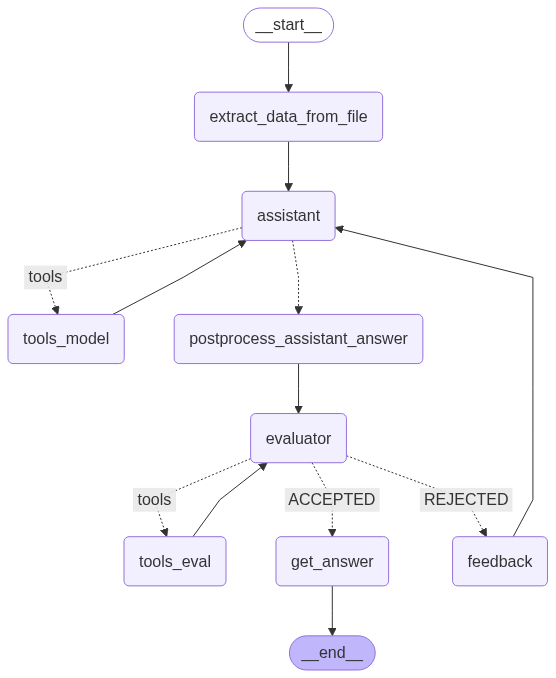

In [ ]:
agent.draw_graph()

# Thank you for your time! 😀
<img src="https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit4/congrats.png">